# Алгоритмическая торговля на примере объёмной дельты (Volume Delta)

**Автор:** Мячин Платон 

---

## Описание проекта

В этом ноутбуке представлено исследование и бэктестинг торговой стратегии на основе **Volume Delta**. Все данные были собраны самостоятельно при помощи собственного **парсера**, реализованного на WebSocket API Bybit. Метрики и индикаторы (Value Area, VPIN, OFI, RF, Kyle’s Lambda, Volume Delta и др.) также написаны с нуля в модуле `functions.py`.

На текущем этапе:
- Фокусируемся исключительно на работе с **Volume Delta** — поиске экстремальных изменений, нормализации относительно средних значений и генерации сигналов входа/выхода.
- Используем формат хранения **parquet** вместо CSV для трёхкратного ускорения чтения и снижения потребления дискового пространства.
- Сигналы тестируются через «галочки» на барах (15 min), а вход/выход по рыночным тикам.

## Возникшие сложности

1. **Перевод CSV → Parquet**  
   Переход к Parquet дал существенное ускорение, но потребовал выстраивания буферизированной записи, синхронизации по датам и фиксации схемы Arrow.

2. **Сдвиг и выравнивание временных рядов**  
   Непросто было согласовать временнýю сетку 15 min—binned индикаторов с тиковыми данными цены и стакана. Приходилось аккуратно выбирать nearest/ffill и следить за NaN.

3. **Динамический TP/SL**  
   Поиск уровней стоп-лосса и тейк-профита на основе ATR/волатильности затронул логику ближайших тиков, что вылилось в серию итераций и баг‑фиксов.

---

> **Дальнейшие планы**:  
> - Расширить эксперимент на остальные индикаторы из `functions.py` (RF, VPIN, OFI, Kyle’s Lambda).  
> - Автоматизировать перебор параметров (Grid Search / Bayesian Optimization).  
> - Интегрировать визуализацию spread/slippage и глубины книги в реальном времени.  

---  


In [1]:
# import sys
# from pathlib import Path          

# sys.path.append(str(Path("src").resolve()))
# import functions

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import functions #свой файл с функциями чтения данных и расчета
import numpy as np
import math, pyarrow.parquet as pq, os, glob
import pandas as pd

In [3]:
start_date, end_date = '2025-08-07', '2025-08-14'
ticks_by_day, ob_by_day = functions.read_files_by_day(start_date, end_date)

In [4]:
def process_order_flow_imbalance_by_day(odf: pd.DataFrame, period: str) -> pd.Series:
    odf = odf.copy()
    odf['recv_time'] = pd.to_datetime(odf['recv_time'])
    period_ns = pd.to_timedelta(period).value

    series_list = []
    for day, g in odf.groupby(odf['recv_time'].dt.normalize()):
        # anchor = midnight текущего дня
        t0 = day.value  # int64 nanos since epoch
        # last nanosecond of the day
        t_last = (day + pd.Timedelta(days=1) - pd.Timedelta(nanoseconds=1)).value
        max_bins = int((t_last - t0) // period_ns) + 1

        # подготовка входных массивов — только для этой группы
        ts_ns   = g['recv_time'].astype('int64').to_numpy()
        typ     = (g['type'] == 'delta').to_numpy(np.int8)
        side    = (g['side'] == 'Sell').to_numpy(np.int8)
        price   = g['price'].to_numpy(np.float64)
        size    = g['size'].to_numpy(np.float64)

        ofi_vals = functions._ofi_numba(ts_ns, typ, side, price, size, t0, period_ns, max_bins)

        bin_times = pd.to_datetime(t0 + np.arange(max_bins, dtype=np.int64) * period_ns)
        s = pd.Series(ofi_vals, index=bin_times, name='OFI')
        series_list.append(s)

    # Соединяем дни в единый Series (index будет упорядочен по времени)
    return pd.concat(series_list).sort_index()

In [5]:
PERIOD_BIG = '1h'
PERIOD_SMALL = '15min'
PERIOD_TINY = '5min'
STEP = 0.5

indicators_by_day = []
last_values = {"24h": None, "1D": None, "1W": None}  # хвосты для разных горизонтов
start_day = None
# total_len_vpin= 0
# total_len_ofi = 0
# total_len_ind = 0

for tick_df, ob_df in zip(ticks_by_day, ob_by_day):
    tick_df = tick_df.copy()
    ob_df = ob_df.copy()

    tick_df['recv_time'] = pd.to_datetime(tick_df['recv_time'])
    ob_df['recv_time']  = pd.to_datetime(ob_df['recv_time'])

    price_bar = (
        tick_df.set_index('recv_time')['price']
            .resample('1min', origin=start_date)
            .last()
            .ffill()
            .rename('price')
    )

    ofi = functions.process_order_flow_imbalance(ob_df, PERIOD_TINY)
    va_df     = functions.value_area(tick_df.copy(), PERIOD_SMALL, STEP)
    delta     = functions.volume_delta(tick_df.copy(), PERIOD_SMALL).rename('volume_delta')
    rf        = functions.RF(va_df)
    vpin = functions.VPIN(tick_df.copy(), PERIOD_SMALL, 1000, '15min')

    # ------------------ cumulative deltas ------------------
    current_day = tick_df['recv_time'].iloc[0].normalize()
    weekday = current_day.weekday()

    deltas_result = []
    for p in ["24h", "1D", "1W"]:
        start_val = last_values[p] if last_values[p] is not None else 0

        if p == "1D":
            start_val = 0  # обнуляем каждый день
        elif p == "1W" and (start_day is None or weekday == 0):
            start_val = 0  # сброс в начале недели

        delta_p = functions.cumulative_delta(tick_df, "1min", start_val)
        delta_p.name = f"cum_delta_{p}"
        last_values[p] = delta_p.iloc[-1]  # обновляем хвост
        deltas_result.append(delta_p)

    start_day = current_day
    cum_deltas_df = pd.concat(deltas_result, axis=1)
    # ------------------ cumulative deltas ------------------

    minute_volume = (#нужно для доп условий индикаторов
        tick_df.set_index('recv_time')['size']
        .resample('1min', origin=start_date)
        .sum()
        .reindex(price_bar.index)
        .fillna(0)
        .rename('minute_volume')
    )
    
    cumulative_volume = minute_volume.cumsum().rename('cumulative_volume')
    
    day_df = pd.concat([delta, va_df, price_bar, rf, minute_volume, cum_deltas_df, cumulative_volume, ofi, vpin], axis=1)
    
    indicators_by_day.append(day_df)

indicators_df = pd.DataFrame(pd.concat(indicators_by_day, axis=0)) #тут был .sort_index()
indicators_df = indicators_df[~indicators_df.index.duplicated(keep='last')]
indicators_df[['VAH', 'VAL']] = indicators_df[['VAH', 'VAL']].ffill()

pd.set_option('display.max_rows', None)  # Все строки
pd.set_option('display.max_columns', None)  # Все столбцы
pd.set_option('display.width', None)  # Автоподбор ширины
pd.set_option('display.max_colwidth', None)  # Полный текст в ячейках
print(indicators_df)

                     volume_delta  POC_price  POC_volume       VAH       VAL  \
2025-08-07 10:30:00    -90.743988   116333.0   53.333000  116334.0  116292.5   
2025-08-07 10:40:00           NaN        NaN         NaN  116334.0  116292.5   
2025-08-07 10:41:00           NaN        NaN         NaN  116334.0  116292.5   
2025-08-07 10:42:00           NaN        NaN         NaN  116334.0  116292.5   
2025-08-07 10:43:00           NaN        NaN         NaN  116334.0  116292.5   
2025-08-07 10:44:00           NaN        NaN         NaN  116334.0  116292.5   
2025-08-07 10:45:00   -600.083069   116300.0   53.307999  116401.5  116252.5   
2025-08-07 10:46:00           NaN        NaN         NaN  116401.5  116252.5   
2025-08-07 10:47:00           NaN        NaN         NaN  116401.5  116252.5   
2025-08-07 10:48:00           NaN        NaN         NaN  116401.5  116252.5   
2025-08-07 10:49:00           NaN        NaN         NaN  116401.5  116252.5   
2025-08-07 10:50:00           NaN       

заполнения времен открытия по индикаторам (на данный момент единственный включенный в исследование индикатор - volume delta, смотрите ниже)

VAH/VAL/POC

In [6]:
def value_area_conditions(indicators_df, horizon='15min', volatile_hours=(12, 18)):

    hour_mask = (indicators_df.index.hour >= volatile_hours[0]) & \
                (indicators_df.index.hour < volatile_hours[1])
    
    va_base = indicators_df.loc[hour_mask, ['VAH', 'VAL', 'price']].copy()
    
    if va_base.empty:
        print("Предупреждение: Нет данных в указанных волатильных часах")
        return indicators_df, pd.DataFrame(), pd.DataFrame()

    future_mean = (
        va_base['price'][::-1]
        .rolling(horizon, min_periods=1)
        .mean()[::-1]
    )
    
    va_base['avg_price'] = future_mean
    
    va_base = va_base.dropna(subset=['VAH', 'VAL'])
    
    P = va_base['price']
    H = va_base['VAH']
    L = va_base['VAL']
    future_mean = va_base['avg_price']
    
    #-----------определение сигналов---------------
    price_near_val = (P <= L * 1.005) & (P >= L * 0.995)
    price_near_vah = (P <= H * 1.005) & (P >= H * 0.995)

    #тренд
    short_trend = P.rolling('30min').mean()
    long_trend = P.rolling('2h').mean()
    is_uptrend = short_trend > long_trend
    is_downtrend = short_trend < long_trend

    val_buy_signals = price_near_val & (P < L) & (P.shift(3) > L.shift(3)) & is_uptrend
    vah_sell_signals = price_near_vah & (P > H) & (P.shift(3) < L.shift(3)) & is_downtrend

    #фильтр по объему -- ДОБАВИТЬ
    if 'minute_volume' in indicators_df.columns:
        volume_filter = indicators_df['minute_volume'] > indicators_df['minute_volume'].rolling('1h').mean()
        val_buy_signals = val_buy_signals & volume_filter
        vah_sell_signals = vah_sell_signals & volume_filter

    #фильтр по волатильности
    volatility = indicators_df['price'].rolling('1h').std()
    volatility_filter = volatility > volatility.rolling('24h').mean()
    val_buy_signals = val_buy_signals & volatility_filter
    vah_sell_signals = vah_sell_signals & volatility_filter

    indicators_df['VAL_buy'] = val_buy_signals
    indicators_df['VAH_sell'] = vah_sell_signals
    #-----------определение сигналов---------------

    delta_price = future_mean - P
    percent_delta_price = (future_mean / P - 1)
    
    # Создание отдельных DataFrame для VAH и VAL статистики
    vah_stats = pd.DataFrame({
        'price_at_signal': P,
        'future_price': future_mean,
        'vah_value': H,
        'delta_price': delta_price,
        'percent_delta': percent_delta_price
    }, index=va_base.index).loc[vah_sell_signals].copy()
    
    val_stats = pd.DataFrame({
        'price_at_signal': P,
        'future_price': future_mean,
        'val_value': L,
        'delta_price': delta_price,
        'percent_delta': percent_delta_price
    }, index=va_base.index).loc[val_buy_signals].copy()
    
    # Добавление дополнительной информации для анализа
    # for stats_df, signal_type in [(vah_stats, 'VAH_sell'), (val_stats, 'VAL_buy')]:
    #     if not stats_df.empty:
    #         stats_df['signal_type'] = signal_type
    #         stats_df['hour'] = stats_df.index.hour
    #         stats_df['weekday'] = stats_df.index.weekday
    
    return indicators_df, vah_stats, val_stats

 отрисовка зависимости изменения цены от VAH, VAL ...

СТАТИСТИКА ПО СИГНАЛАМ VAH/VAL
VAL_buy: рост в 77.8% случаев, среднее изменение: 0.0752%
VAH_sell: падение в 100.0% случаев, среднее изменение: -0.1274%


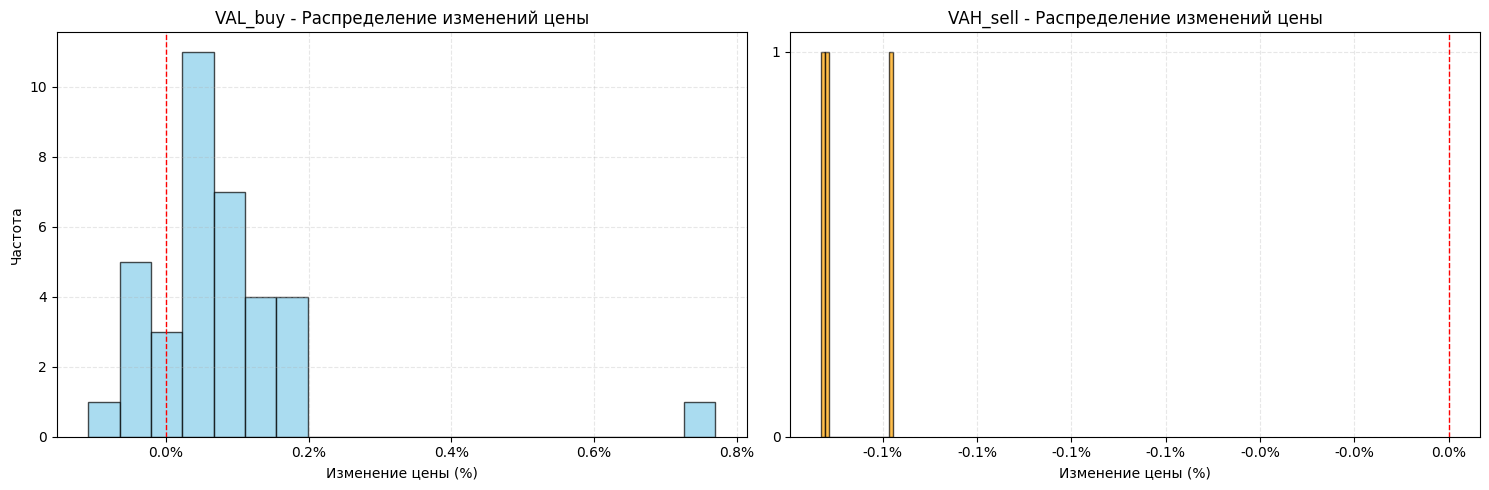

In [7]:
from matplotlib.ticker import MaxNLocator, FuncFormatter

# Получаем данные
indicators_df_, vah_stats, val_stats = value_area_conditions(indicators_df)

# Вывод статистики
print("=" * 50)
print("СТАТИСТИКА ПО СИГНАЛАМ VAH/VAL")
print("=" * 50)

if not val_stats.empty:
    val_change = val_stats['percent_delta']
    print(f"VAL_buy: рост в {(val_change > 0).mean():.1%} случаев, "
          f"среднее изменение: {val_change.mean():.4%}")
else:
    print("VAL_buy: нет данных для анализа")

if not vah_stats.empty:
    vah_change = vah_stats['percent_delta']
    print(f"VAH_sell: падение в {(vah_change < 0).mean():.1%} случаев, "
          f"среднее изменение: {vah_change.mean():.4%}")
else:
    print("VAH_sell: нет данных для анализа")

# Создаем графики только если есть данные
if not val_stats.empty or not vah_stats.empty:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Гистограмма для VAL_buy
    if not val_stats.empty:
        axes[0].hist(val_stats['percent_delta'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
        axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
        axes[0].set_title('VAL_buy - Распределение изменений цены')
        axes[0].set_xlabel('Изменение цены (%)')
        axes[0].set_ylabel('Частота')
    
    # Гистограмма для VAH_sell
    if not vah_stats.empty:
        axes[1].hist(vah_stats['percent_delta'], bins=20, color='orange', alpha=0.7, edgecolor='black')
        axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
        axes[1].set_title('VAH_sell - Распределение изменений цены')
        axes[1].set_xlabel('Изменение цены (%)')
    
    # Форматирование осей
    for ax in axes:
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для построения графиков")

ROTATION FACTOR

In [8]:
'''-----------------------анализ RF-----------------------'''
def rf_conditions(indicators_df, n=15, z_window='24h', z_thresh=1.2):
    rf_base = indicators_df[['RF', 'price']]

    future_mean = (
        rf_base['price']
        .rolling('15min', closed='right')
        .mean()
        .shift(-1)  # чтобы смотреть вперёд
    )

    rf_base['avg_price'] = future_mean.where(rf_base['RF'].notna())

    rf_base = rf_base.dropna()
    print(rf_base)

    rf = rf_base['RF']
    P = rf_base['price']
    avg_pr = rf_base['avg_price']

    # Z-score
    rf_z = (rf - rf.rolling(z_window).mean()) / rf.rolling(z_window).std()

    # условия сигналов
    rf_buy  = rf_z < -z_thresh
    rf_sell = rf_z > +z_thresh

    indicators_df['rf_buy']  = rf_buy.fillna(False)
    indicators_df['rf_sell'] = rf_sell.fillna(False)

    # изменение цены через n шагов
    delta_price = (avg_pr - P).rename('delta_price')
    percent_delta_price = (avg_pr / P - 1).rename('percent_delta_price')

    rf_signals = pd.DataFrame({
        'RF': rf,
        'rf_z': rf_z,
        'delta_price': delta_price,
        'percent_delta_price': percent_delta_price,
        'rf_buy': rf_buy,
        'rf_sell': rf_sell
    }).dropna()

    print("rf_buy sum:", rf_buy.sum(), "rf_sell sum:", rf_sell.sum())

    return indicators_df, rf_signals
'''-------------------------------------------------------'''

'-------------------------------------------------------'

визуализация RF

                            RF          price      avg_price
2025-08-07 10:45:00   2.136842  116352.398438  116307.156250
2025-08-07 11:00:00   4.000000  116377.796875  116301.345833
2025-08-07 11:15:00  10.000000  116389.898438  116391.427083
2025-08-07 11:30:00   1.980198  116666.296875  116627.239062
2025-08-07 11:45:00   6.948718  116609.000000  116546.920313
2025-08-07 12:00:00   5.538462  116440.000000  116562.367708
2025-08-07 12:15:00   2.442105  116280.296875  116304.885938
2025-08-07 12:30:00   0.958621  116313.601562  116264.860417
2025-08-07 12:45:00   4.295455  116186.000000  116303.733854
2025-08-07 13:00:00   0.156951  116324.796875  116226.664062
2025-08-07 13:15:00   5.972973  116165.101562  116223.906250
2025-08-07 13:30:00   0.610922  116330.000000  116286.026042
2025-08-07 13:45:00   0.314050  116373.000000  116504.101042
2025-08-07 14:00:00   0.081037  116588.703125  116538.966667
2025-08-07 14:15:00   0.208835  116215.203125  116328.986458
2025-08-07 14:30:00   1.

/var/folders/9g/ksvcj0yd2b714fy6c81b26v00000gn/T/ipykernel_19068/3002325516.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_base['avg_price'] = future_mean.where(rf_base['RF'].notna())


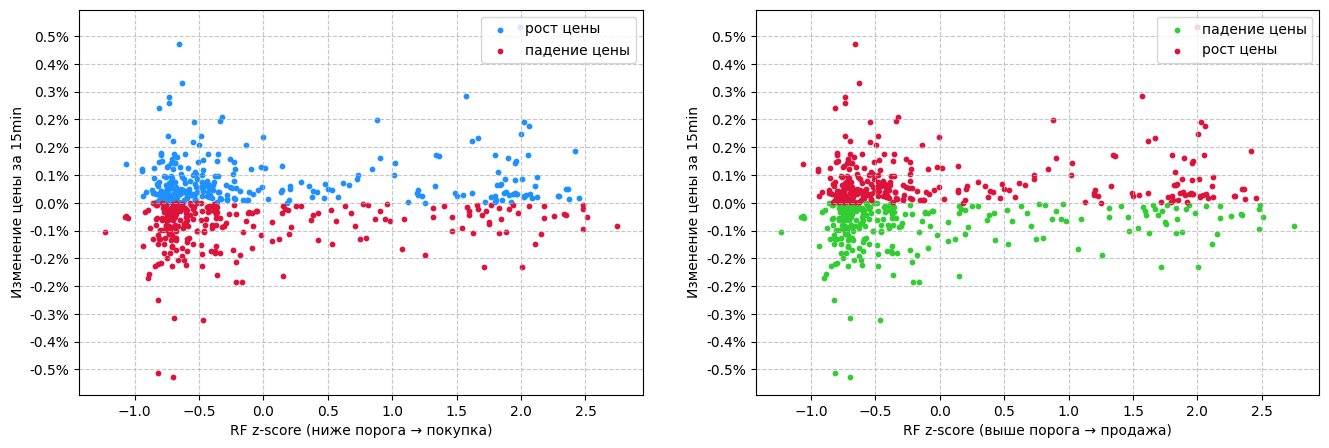

In [9]:
indicators_df_, rf_ratios = rf_conditions(indicators_df)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# для покупок: RF ниже порога (отрицательный z)
rf_buy_case_good = rf_ratios['delta_price'] >= 0
rf_buy_case_bad  = rf_ratios['delta_price'] < 0

# для продаж: RF выше порога (положительный z)
rf_sell_case_good = rf_ratios['delta_price'] <= 0
rf_sell_case_bad  = rf_ratios['delta_price'] > 0

# Лонг-сигналы
axes[0].scatter(
    rf_ratios[rf_buy_case_good]['rf_z'],
    rf_ratios[rf_buy_case_good]['percent_delta_price'],
    color='dodgerblue', s=10, label='рост цены'
)
axes[0].scatter(
    rf_ratios[rf_buy_case_bad]['rf_z'],
    rf_ratios[rf_buy_case_bad]['percent_delta_price'],
    color='crimson', s=10, label='падение цены'
)
axes[0].legend(loc='upper right')
axes[0].set_xlabel('RF z-score (ниже порога → покупка)')

# Шорт-сигналы
axes[1].scatter(
    rf_ratios[rf_sell_case_good]['rf_z'],
    rf_ratios[rf_sell_case_good]['percent_delta_price'],
    color='limegreen', s=10, label='падение цены'
)
axes[1].scatter(
    rf_ratios[rf_sell_case_bad]['rf_z'],
    rf_ratios[rf_sell_case_bad]['percent_delta_price'],
    color='crimson', s=10, label='рост цены'
)
axes[1].legend(loc='upper right')
axes[1].set_xlabel('RF z-score (выше порога → продажа)')

# общий стиль
for ax in axes:
    ax.yaxis.set_major_locator(MaxNLocator(nbins=15))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel(f'Изменение цены за {PERIOD_SMALL}', fontsize=10)

# Статистика
buy_cases  = rf_ratios[rf_ratios['rf_buy']]
sell_cases = rf_ratios[rf_ratios['rf_sell']]

buy_total  = len(buy_cases)
sell_total = len(sell_cases)

buy_good = (buy_cases['delta_price'] >= 0).sum()
sell_good = (sell_cases['delta_price'] <= 0).sum()

buy_good_pct  = 100 * buy_good / buy_total if buy_total > 0 else 0
sell_good_pct = 100 * sell_good / sell_total if sell_total > 0 else 0

buy_avg_change  = buy_cases['percent_delta_price'].mean() * 100 if buy_total > 0 else 0
sell_avg_change = sell_cases['percent_delta_price'].mean() * 100 if sell_total > 0 else 0

print(f"Лонг-сигналы (RF < -порог): рост в {buy_good_pct:.1f}% случаев, "
      f"среднее изменение {buy_avg_change:.6f}%")

print(f"Шорт-сигналы (RF > +порог): падение в {sell_good_pct:.1f}% случаев, "
      f"среднее изменение {sell_avg_change:.6f}%")


VPIN

In [10]:
def vpin_conditions(indicators_df, horizon='15min', volatile_hours=(10, 22), threshold = 2):
    ROLLING_MEAN_WINDOW = '24h'

    hour_mask = (indicators_df.index.hour >= volatile_hours[0]) & \
                (indicators_df.index.hour < volatile_hours[1])
    
    vpin_base = indicators_df.loc[hour_mask, ['VPIN', 'price']].copy()
    P = vpin_base['price']
    if vpin_base.empty:
        print("Предупреждение: Нет данных в указанных волатильных часах")
        return indicators_df, pd.DataFrame(), pd.DataFrame()

    future_mean = (
        vpin_base['price'][::-1]
        .rolling(horizon, min_periods=1)
        .mean()[::-1]
    )
    
    vpin = vpin_base['VPIN']

    vpin_base['avg_price'] = future_mean
    vpin_base = vpin_base.dropna(subset=['VPIN'])
    future_mean = vpin_base['avg_price']
    
    #-----------определение сигналов---------------
    vpin_base['avg_vpin'] = vpin.rolling(window=ROLLING_MEAN_WINDOW).mean()
    ratio = vpin / vpin_base['avg_vpin']
    vpin_ban_trade = ratio > threshold
    #-----------определение сигналов---------------

    abs_delta_price = abs(future_mean - P)
    abs_percent_delta_price = abs(future_mean / P - 1)

    vpin_general_stats = pd.DataFrame({
        'price_at_signal': P,
        'future_price': future_mean,
        'vpin_value': vpin,
        'ratio' : ratio,
        'delta_price': abs_delta_price,
        'percent_delta': abs_percent_delta_price
    }, index=vpin_base.index).copy()
    
    return indicators_df, vpin_general_stats

визуализация VPIN

Text(0, 0.5, 'Изменение цены за 15min')

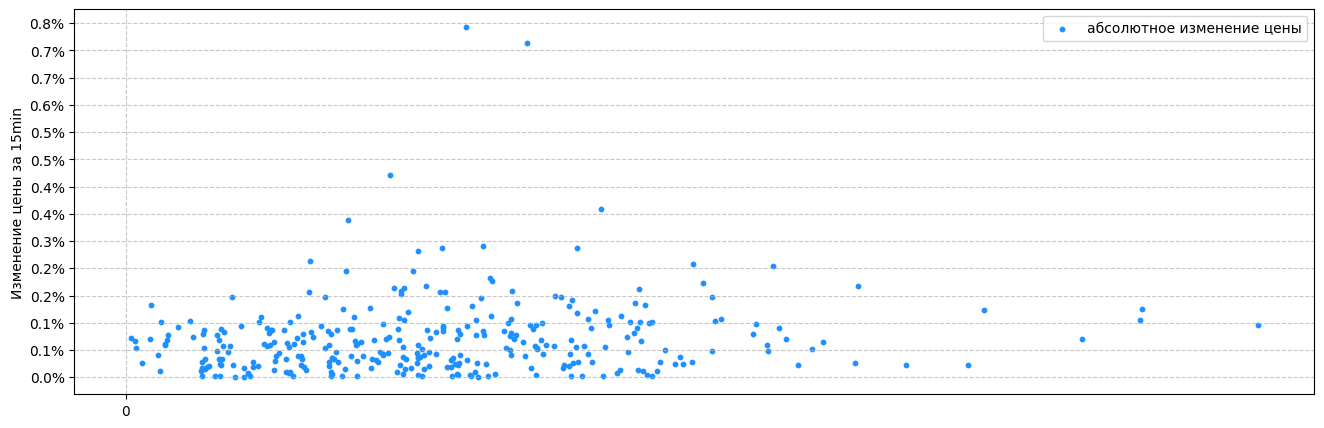

In [11]:
from matplotlib.ticker import MultipleLocator, MaxNLocator, FuncFormatter

indicators_df_, general_df = vpin_conditions(indicators_df)

fig, ax = plt.subplots(
    1, 1,
    figsize=(16, 5)
)

ax.scatter(general_df['ratio'], general_df['percent_delta'], color = 'dodgerblue', s=10, label='абсолютное изменение цены')
ax.legend(loc='upper right')

# ось y
ax.yaxis.set_major_locator(MaxNLocator(nbins=15))  # 15 делений по Y

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))

# ось х
ax.xaxis.set_major_locator(MultipleLocator(5))

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_ylabel(f'Изменение цены за {PERIOD_SMALL}', fontsize=10)

In [12]:
P = indicators_df['price']

OFI

In [13]:
'''-----------------------изменение ofi-----------------------'''
def ofi_conditions(indicators_df, threshold_long, threshold_short,
                  cum_window='45min', volatile_hours=(12, 18)):
    """
    volatile_hours: кортеж (start_hour, end_hour) определяющий волатильные часы
    По умолчанию: с 8:00 до 22:00 (14-часовое окно)
    """
    
    # Создаем маску для волатильных часов
    hour_mask = (indicators_df.index.hour >= volatile_hours[0]) & \
                (indicators_df.index.hour < volatile_hours[1])
    
    # Фильтруем данные только по волатильным часам
    ofi_base = indicators_df.loc[hour_mask, ['OFI', 'price']].copy()
    
    # Проверяем, что у нас достаточно данных
    if ofi_base.empty:
        print("Предупреждение: Нет данных в указанных волатильных часах")
        return indicators_df, pd.DataFrame()

    future_mean = (
        ofi_base[::-1]['price']          # переворачиваем индекс
        .rolling('15min', min_periods=1) # теперь окно реально смотрит вперёд во времени
        .mean()
    )[::-1]                              # переворачиваем обратно

    ofi_base['avg_price'] = future_mean.where(ofi_base['OFI'].notna())
    ofi_base = ofi_base.dropna()
    # print(ofi_base)

    ofi_base['cum_ofi'] = ofi_base['OFI'].rolling(cum_window).sum()
    P = ofi_base['price']
    cum_ofi = ofi_base['cum_ofi']
    # ofi = ofi_base['OFI']

    # разделение на положительные и отрицательные части
    pos_ofi = cum_ofi.clip(lower=0)
    neg_ofi = cum_ofi.clip(upper=0)

    # средние значения для нормализации (по скользящему окну)
    avg_pos = pos_ofi.rolling('24h').mean().shift(1)
    avg_neg = neg_ofi.rolling('24h').mean().shift(1)

    # условия входа (теперь на основе cum_ofi)
    ofi_open_long = abs(cum_ofi / avg_pos.replace(0, np.nan)) >= threshold_long
    ofi_open_short = abs(cum_ofi / avg_neg.replace(0, np.nan)) >= threshold_short

    indicators_df['ofi_open_long'] = ofi_open_long
    indicators_df['ofi_open_short'] = ofi_open_short

    delta_price = (future_mean - P).rename('delta_price')
    percent_delta_price = (future_mean / P - 1).rename('percent_delta_price')

    # DataFrame для анализа сигналов
    ofi_ratios = pd.DataFrame({
        'cum_ofi': cum_ofi,
        'avg_pos': avg_pos,
        'avg_neg': avg_neg,
        'ratio_pos': (pos_ofi / avg_pos.replace(0, np.nan)).clip(upper=50).fillna(0),
        'ratio_neg': (neg_ofi / avg_neg.replace(0, np.nan)).clip(upper=50).fillna(0),
        'delta_price': delta_price,
        'percent_delta_price': percent_delta_price,
        'ofi_open_long': ofi_open_long,
        'ofi_open_short': ofi_open_short
    }).dropna()

    return indicators_df, ofi_ratios
'''------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------'

отрисовка OFI

Лонг-сигналы: рост в 64.0% случаев, среднее изменение 0.014026%
Шорт-сигналы: падение в 50.9% случаев, среднее изменение -0.055930%


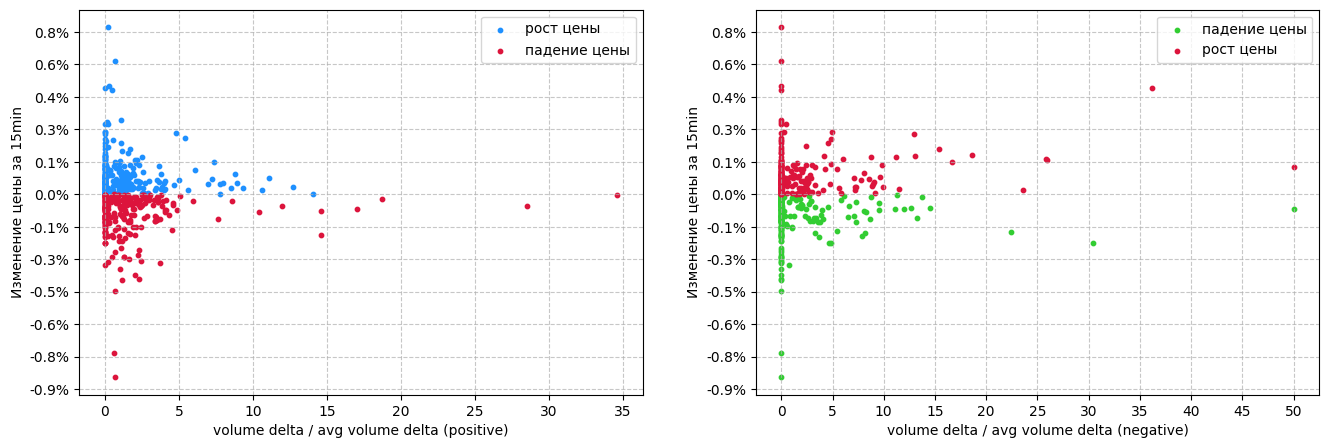

In [14]:
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter


indicators_df_, ofi_ratios = ofi_conditions(indicators_df, 40, 40)

fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 5)
)

#при входе в лонг по сигналу с большой положительной дельтой увеличение цены - хорошо, уменьшение - плохо
pos_good_case = ofi_ratios['delta_price'] >= 0
pos_bad_case = ofi_ratios['delta_price'] < 0

#для шорта наоборот
neg_good_case = ofi_ratios['delta_price'] <= 0
neg_bad_case = ofi_ratios['delta_price'] > 0

axes[0].scatter(ofi_ratios[pos_good_case]['ratio_pos'], ofi_ratios[pos_good_case]['percent_delta_price'], color = 'dodgerblue', s=10, label='рост цены')
axes[0].scatter(ofi_ratios[pos_bad_case]['ratio_pos'], ofi_ratios[pos_bad_case]['percent_delta_price'], color = 'crimson', s=10, label='падение цены')
axes[0].legend(loc='upper right')

axes[1].scatter(ofi_ratios[neg_good_case]['ratio_neg'], ofi_ratios[neg_good_case]['percent_delta_price'], color = 'limegreen', s=10, label='падение цены')
axes[1].scatter(ofi_ratios[neg_bad_case]['ratio_neg'], ofi_ratios[neg_bad_case]['percent_delta_price'], color = 'crimson', s=10, label='рост цены')
axes[1].legend(loc='upper right')

axes[0].set_xlabel('volume delta / avg volume delta (positive)')

axes[1].set_xlabel('volume delta / avg volume delta (negative)')

for ax in axes:
    # ось y
    ax.yaxis.set_major_locator(MaxNLocator(nbins=15))  # 15 делений по Y
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))

    # ось х
    ax.xaxis.set_major_locator(MultipleLocator(5))
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel(f'Изменение цены за {PERIOD_SMALL}', fontsize=10)

# Статистика 
long_signals = ofi_ratios[ofi_ratios['ofi_open_long']]
short_signals = ofi_ratios[ofi_ratios['ofi_open_short']]

long_success_rate = len(long_signals[long_signals['percent_delta_price'] >= 0]) / len(long_signals) * 100
short_success_rate = len(short_signals[short_signals['percent_delta_price'] < 0]) / len(short_signals) * 100

print(f"Лонг-сигналы: рост в {long_success_rate:.1f}% случаев, "
      f"среднее изменение {long_signals['percent_delta_price'].mean() * 100:.6f}%")
print(f"Шорт-сигналы: падение в {short_success_rate:.1f}% случаев, "
      f"среднее изменение {short_signals['percent_delta_price'].mean() * 100:.6f}%")

VOLUME DELTA

In [15]:

'''-----------------------изменение volume delta-----------------------'''
def vol_del_conditions(indicators_df, threshold_long, threshold_short, volatile_hours = (12, 18)):

    hour_mask = (indicators_df.index.hour >= volatile_hours[0]) & \
                (indicators_df.index.hour < volatile_hours[1])
    
    # Фильтруем данные только по волатильным часам
    vol_base = indicators_df.loc[hour_mask, ['volume_delta', 'price']].copy()

    future_mean = (
        vol_base[::-1]['price']          # переворачиваем индекс
        .rolling('15min', min_periods=1) # теперь окно реально смотрит вперёд во времени
        .mean()
    )[::-1]                              # переворачиваем обратно

    vol_base['avg_price'] = future_mean.where(vol_base['volume_delta'].notna())
    vol_base = vol_base.dropna()
    P = vol_base['price']

    neg_delta = vol_base['volume_delta'].clip(None, 0)#дельта < 0
    pos_delta = vol_base['volume_delta'].clip(0, None)#дельта > 0

    avg_neg_delta = neg_delta.rolling('24h').mean().shift(1)#cреднее значение дельты < 0
    avg_pos_delta = pos_delta.rolling('24h').mean().shift(1)#cреднее значение дельты > 0

    avg_pos_delta = avg_pos_delta.replace(0, np.nan)
    avg_neg_delta = avg_neg_delta.replace(0, np.nan)
    
    #true false значения по индикаторам
    vol_open_long  = (
        ((vol_base['volume_delta']) / (avg_pos_delta)) >= threshold_long
    )

    vol_open_short  = (
        ((vol_base['volume_delta']) / (avg_neg_delta)) >= threshold_short
    )

    #колонка с true false вход/не вход в позицию в конкретный момент
    indicators_df['vol_open_long']  = vol_open_long
    indicators_df['vol_open_short'] = vol_open_short

    delta_price = (future_mean - P).rename('delta_price')
    percent_delta_price = (future_mean / P - 1).rename('percent_delta_price')

    #создаю dataframe с двумя отношениями о которых говорил выше (отрицательный к отрицательному и положительный к положительному)
    vol_ratios = pd.DataFrame({
        'avg_neg': avg_neg_delta,
        'avg_pos': avg_pos_delta,
        'del_neg': neg_delta,
        'del_pos': pos_delta,
        'ratio_pos': (pos_delta / avg_pos_delta).clip(None, 30),#отношения выше 30 можно считать за случайные экстремальные (допустим когда средняя дельта за день -> 0)
        'ratio_neg': (neg_delta / avg_neg_delta).clip(None, 30),
        'delta_price': delta_price,
        'persent_del_price' : percent_delta_price,
        'vol_open_long' : vol_open_long,
        'vol_open_short' : vol_open_short
    }).dropna()

    vol_long_stats = pd.DataFrame({
        'price_at_signal': P,
        'future_price': future_mean,
        'vol_value': vol_base['volume_delta'],
        'delta_price': delta_price,
        'percent_delta': percent_delta_price
    }, index=vol_base.index).loc[vol_open_long].copy()

    vol_short_stats = pd.DataFrame({
        'price_at_signal': P,
        'future_price': future_mean,
        'vol_value': vol_base['volume_delta'],
        'delta_price': delta_price,
        'percent_delta': percent_delta_price
    }, index=vol_base.index).loc[vol_open_short].copy()

    return indicators_df, vol_ratios, vol_long_stats, vol_short_stats

'''------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------'

отрисовка графика volumme delta

тут начинается самое интересное, ниже графики на которых
ось x - отношение volume дельта для каждого посчитанного периода к средней volume delta за 24часа (разделены на положительные и отрицательные);
ось y - процент изменения цены между той, при которой было зафиксировано отношения и ценой через 15 минут (PERIOD_SMALL);

СТАТИСТИКА ПО СИГНАЛАМ VOLUME DELTA
Рост цены после long-сигнала в 100.0% случаев, среднее изменение: 0.1608%
Падение цены после short-сигнала в 100.0% случаев, среднее изменение: -0.1953%


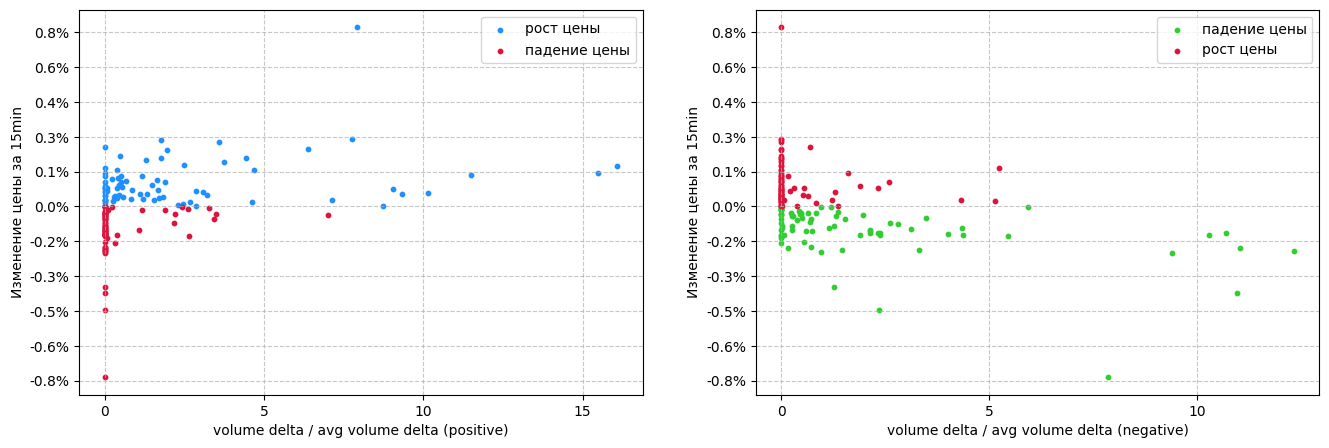

In [16]:
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter


indicators_df_, ofi_ratios, vol_long_stats, vol_short_stats = vol_del_conditions(indicators_df, 15, 10)
#прошлый thresh short 30.55555555555557

fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 5)
)

#при входе в лонг по сигналу с большой положительной дельтой увеличение цены - хорошо, уменьшение - плохо
pos_good_case = ofi_ratios['delta_price'] >= 0
pos_bad_case = ofi_ratios['delta_price'] < 0

#для шорта наоборот
neg_good_case = pos_bad_case
neg_bad_case = pos_good_case

axes[0].scatter(ofi_ratios[pos_good_case]['ratio_pos'], ofi_ratios[pos_good_case]['persent_del_price'], color = 'dodgerblue', s=10, label='рост цены')
axes[0].scatter(ofi_ratios[pos_bad_case]['ratio_pos'], ofi_ratios[pos_bad_case]['persent_del_price'], color = 'crimson', s=10, label='падение цены')
axes[0].legend(loc='upper right')

axes[1].scatter(ofi_ratios[neg_good_case]['ratio_neg'], ofi_ratios[neg_good_case]['persent_del_price'], color = 'limegreen', s=10, label='падение цены')
axes[1].scatter(ofi_ratios[neg_bad_case]['ratio_neg'], ofi_ratios[neg_bad_case]['persent_del_price'], color = 'crimson', s=10, label='рост цены')
axes[1].legend(loc='upper right')

axes[0].set_xlabel('volume delta / avg volume delta (positive)')

axes[1].set_xlabel('volume delta / avg volume delta (negative)')

for ax in axes:
    # ось y
    ax.yaxis.set_major_locator(MaxNLocator(nbins=15))  # 15 делений по Y
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))

    # ось х
    ax.xaxis.set_major_locator(MultipleLocator(5))
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel(f'Изменение цены за {PERIOD_SMALL}', fontsize=10)

# Вывод статистики
print("=" * 50)
print("СТАТИСТИКА ПО СИГНАЛАМ VOLUME DELTA")
print("=" * 50)

if not vol_long_stats.empty:
    vol_long_change = vol_long_stats['percent_delta']
    print(f"Рост цены после long-сигнала в {(vol_long_change > 0).mean():.1%} случаев, "
          f"среднее изменение: {vol_long_change.mean():.4%}")
else:
    print("после long-сигналов нет данных для анализа")

if not vol_short_stats.empty:
    vol_short_change = vol_short_stats['percent_delta']
    print(f"Падение цены после short-сигнала в {len(vol_short_change > 0) / len(vol_short_change):.1%} случаев, "
          f"среднее изменение: {vol_short_change.mean():.4%}")
else:
    print("после short-сигналов нет данных для анализа")

получаем графики где визуально можем определить коэффицент отношения выше которого "хороших" случаев заметно больше чем "плохих", записываем эти значения в переменную threshold

вход в позиции

In [17]:
def create_opens(indicators_df):

    open_pos_long = (
        indicators_df['vol_open_long']
        # & 
        # indicators_df['VAL_buy']
        # &
        # indicators_df['ofi_open_long']
        # &
        # indicators_df['rf_buy']
    )

    open_pos_short = (
        indicators_df['vol_open_short'] 
        # & 
        # indicators_df['VAH_sell']
        # &
        # indicators_df['ofi_open_short']
        # &
        # indicators_df['rf_sell']
    )

    #открытие и закрытие позиций    
    longs_open  = indicators_df.index[ open_pos_long.fillna(False) ].unique()
    # longs_open  = None
    shorts_open = indicators_df.index[ open_pos_short.fillna(False) ].unique()

    return longs_open, shorts_open

анализ тренда с помощью cumulative delta + EMA

In [18]:
def calc_ema(prices: pd.Series, period: int, prev_ema: float = None):
    alpha = 2 / (period + 1)
    arr = prices.to_numpy()
    ema = np.empty(len(arr))
    ema[:] = np.nan

    if prev_ema is None:
        if len(ema) >= period:
            ema[period-1] = arr[:period].mean()
            start = period
        else:
            ema[len(ema)-1] = arr[:period].mean()
            start = len(ema)
    else:
        ema[0] = alpha * arr[0] + (1 - alpha) * prev_ema
        start = 1

    for i in range(start, len(arr)):
        ema[i] = alpha * arr[i] + (1 - alpha) * ema[i-1]

    return pd.Series(ema, index=prices.index, name=f'EMA{period}'), ema[-1]#это и есть prev_ema т.е последнее значение предыдущего списка


In [19]:
def ema_and_ticks_for_exit(df_today, prev_ema, period_ema: int):
    ticks = df_today.set_index('recv_time')['price']
    ticks = ticks[~ticks.index.duplicated(keep='first')]
    ticks_resampled = ticks.resample('1min', origin=start_date).last().dropna()

    # print(ticks_resampled)

    day_ema, prev_ema = calc_ema(ticks_resampled, period_ema, prev_ema)

    return day_ema, ticks, prev_ema


In [20]:
ema_series_all = []
ticks_all = []

for i, df_day in enumerate(ticks_by_day):
    if i == 0:
        ema_series, ticks_df, prev_ema = ema_and_ticks_for_exit(df_day, None, 300)
    else:
        ema_series, ticks_df, prev_ema = ema_and_ticks_for_exit(df_day, prev_ema, 300)

    ema_series_all.append(ema_series)
    ticks_all.append(ticks_df)

# Склеиваем результат
ema_all = pd.concat(ema_series_all).to_frame()
ticks_all = pd.concat(ticks_all)

ema_all = ema_all[~ema_all.index.duplicated(keep='first')]
ticks_all = ticks_all[~ticks_all.index.duplicated(keep='first')]


In [21]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

def analyze_trend(indicators_df, open_ts, ema_df, ema_period, horizons=["1D", "1W", "1M"], price_col="price", delta_col="cum_delta_24h"):
    results = {}
    # print(type(ema_df))
    # now = indicators_df.index.max()  # последний доступный timestamp

    for horizon in horizons:
        if horizon.endswith("D"):
            window = pd.Timedelta(horizon)
        elif horizon.endswith("W"):
            window = pd.Timedelta(weeks=int(horizon[:-1]))
        elif horizon.endswith("M"):
            # приближение: считаем месяц как 30 дней
            window = pd.Timedelta(days=30*int(horizon[:-1]))
        else:
            raise ValueError(f"Неизвестный формат горизонта: {horizon}")

        start_time = open_ts - window
        df_window = indicators_df.loc[start_time:open_ts, [price_col, delta_col]].dropna()
        ema_window = ema_df.loc[start_time:open_ts, [f'EMA{ema_period}']].dropna()

        if df_window.empty or len(df_window) < 5:
            results[horizon] = {"trend": "нет данных"}
            continue

        if ema_window.empty or len(df_window) < 5:
            results[horizon] = {"trend": "нет данных"}
            continue

        merged = df_window.join(ema_window, how="inner")  

        t = (merged.index.astype("int64") // 1e9)  # наносекунды → секунды
        t = (t - t.min()).values.reshape(-1, 1)       # сдвигаем так, чтобы начало = 0
        X = t

        # --- EMA ---
        y_ema = merged[f'EMA{ema_period}'].dropna().values.reshape(-1, 1)
        reg_ema = LinearRegression().fit(X[-len(y_ema):], y_ema)

        # --- готовим данные для CD ---
        # X = np.arange(len(df_window)).reshape(-1, 1)
        y_delta = merged[delta_col].values.reshape(-1, 1)
        y_price = merged[price_col].values.reshape(-1, 1)

        # --- считаем наклон регрессии CD---
        reg_delta = LinearRegression().fit(X, y_delta)
        reg_price = LinearRegression().fit(X, y_price)

        slope_delta = reg_delta.coef_[0][0]
        slope_price = reg_price.coef_[0][0]
        slope_ema = reg_ema.coef_[0][0]

        # --- классификация тренда ---
        if slope_delta > 0 and slope_price > 0:
            trend = "бычий"
        elif slope_delta < 0 and slope_price < 0:
            trend = "медвежий"
        elif slope_delta > 0 and slope_price <= 0:
            trend = "слабый рынок (поглощение покупок)"
        elif slope_delta < 0 and slope_price >= 0:
            trend = "сильный рынок (поглощение продаж)"
        else:
            trend = "нейтральный"

        results[horizon] = {
            "slope_delta": slope_delta,
            "slope_price": slope_price,
            "slope_ema": slope_ema,
            "trend": trend,
            "points_used": len(df_window),
            "start": df_window.index.min(),
            "end": df_window.index.max()
        }

    return results


longs_open, shorts_open = create_opens(indicators_df)
# print(longs_open)
# print(shorts_open)

trend_stats_long = []
trend_stats_short = []
for ts in longs_open:
    trend_stats_long.append(analyze_trend(indicators_df, ts, ema_all, 300, horizons=["1D", "1W"]))
    
for ts in shorts_open:
    trend_stats_short.append(analyze_trend(indicators_df, ts, ema_all, 300, horizons=["1D", "1W"]))

for i, output in enumerate(trend_stats_long):
    for horizon, stats in output.items():
        print(f"для времени {longs_open[i]} {horizon}: {stats['trend']} (наклон CD={stats.get('slope_delta')}, наклон EMA={stats.get('slope_ema')} наклон цены={stats.get('slope_price')}, точек={stats.get('points_used')})")

for i, output in enumerate(trend_stats_short):
    for horizon, stats in output.items():
        print(f"для времени {shorts_open[i]} {horizon}: {stats['trend']} (наклон CD={stats.get('slope_delta')}, наклон EMA={stats.get('slope_ema')} наклон цены={stats.get('slope_price')}, точек={stats.get('points_used')})")


для времени 2025-08-07 13:30:00 1D: нет данных (наклон CD=None, наклон EMA=None наклон цены=None, точек=None)
для времени 2025-08-07 13:30:00 1W: нет данных (наклон CD=None, наклон EMA=None наклон цены=None, точек=None)
для времени 2025-08-12 13:45:00 1D: медвежий (наклон CD=-0.07621098929544613, наклон EMA=-0.021670351357843325 наклон цены=-0.016389043301424516, точек=1441)
для времени 2025-08-12 13:45:00 1W: бычий (наклон CD=0.0048224899434985, наклон EMA=0.009028390393798831 наклон цены=0.008797158838910295, точек=5358)
для времени 2025-08-11 12:00:00 1D: бычий (наклон CD=0.06468323717936308, наклон EMA=0.05172035735920598 наклон цены=0.04930804707243366, точек=1441)
для времени 2025-08-11 12:00:00 1W: бычий (наклон CD=0.010413829108023364, наклон EMA=0.012138162665995891 наклон цены=0.013630539553862354, точек=3813)
для времени 2025-08-11 12:30:00 1D: бычий (наклон CD=0.06499704953791867, наклон EMA=0.05112706537989099 наклон цены=0.04766410551203367, точек=1441)
для времени 2025-0

/var/folders/9g/ksvcj0yd2b714fy6c81b26v00000gn/T/ipykernel_19068/2579997752.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  longs_open  = indicators_df.index[ open_pos_long.fillna(False) ].unique()
/var/folders/9g/ksvcj0yd2b714fy6c81b26v00000gn/T/ipykernel_19068/2579997752.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shorts_open = indicators_df.index[ open_pos_short.fillna(False) ].unique()


In [110]:
horizons = ['1D', '1W']
names = ['slope_price', 'slope_delta', 'slope_ema']
trends = ['бычий', 'медвежий']

df_long = pd.json_normalize(
    trend_stats_long,
    meta=[longs_open],  # Добавляем временные метки
    meta_prefix='timestamp_'
)
df_long['type'] = 'long'  # Добавляем тип сделки

# Создаем DataFrame для short сделок
df_short = pd.json_normalize(
    trend_stats_short,
    meta=[shorts_open],
    meta_prefix='timestamp_'
)
df_short['type'] = 'short'

# Объединяем оба DataFrame
df_combined = pd.concat([df_long, df_short], ignore_index=True)
# df_combined.set_index('meta.timestamp_0').rename('recv_time')
for horizon in horizons:
    for name in names:
        for trend in trends:
            df_combined[f'avg_{name}_{horizon}_{trend}'] = df_combined[df_combined[f'{horizon}.trend'] == trend][f'{horizon}.{name}'].mean()

print(df_combined)

     1D.trend    1W.trend  1D.slope_delta  1D.slope_price  1D.slope_ema  \
0  нет данных  нет данных             NaN             NaN           NaN   
1    медвежий       бычий       -0.076211       -0.016389     -0.021670   
2       бычий       бычий        0.064683        0.049308      0.051720   
3       бычий       бычий        0.064997        0.047664      0.051127   
4       бычий       бычий        0.051424        0.021332      0.023786   
5       бычий       бычий        0.018377        0.018078      0.012574   
6       бычий       бычий        0.018769        0.019996      0.012768   

   1D.points_used            1D.start              1D.end  1W.slope_delta  \
0             NaN                 NaT                 NaT             NaN   
1          1441.0 2025-08-11 13:45:00 2025-08-12 13:45:00        0.004822   
2          1441.0 2025-08-10 12:00:00 2025-08-11 12:00:00        0.010414   
3          1441.0 2025-08-10 12:30:00 2025-08-11 12:30:00        0.010541   
4           68

динамический TP/SL с помощью EMA

EMA


расчет TP/SL по EMA

In [22]:
# def get_nearest_tick(ts, ticks, method):
#     pos = ticks.index.get_indexer([ts], method=method)[0]
#     return pos

# def find_exit_point(open_ts, direction, RISK_REWARD_RATIO, coeff, ticks, ema_df, ema_period):
#     ticks_pos = get_nearest_tick(open_ts, ticks, 'nearest')# ТУТ мб РАСХОЖДЕНИЕ МЕЖДУ НАЙДЕННОЙ ЦЕНОЙ И ПРИСВОЕННЫМ ВРЕМЕНЕМ
#     entry_price = ticks.iloc[ticks_pos]

#     ema_pos = get_nearest_tick(open_ts, ema_df, 'ffill')
#     ema_val = ema_df.iloc[ema_pos]

#     # считаем SL/TP от EMA
#     sl_amount = abs(entry_price - ema_val) * coeff
#     tp_amount = sl_amount * RISK_REWARD_RATIO

#     future = ticks.iloc[ticks_pos+1:] 

#     if direction == 'long':
#         sl_price = entry_price - sl_amount
#         tp_price = entry_price + tp_amount

#         ts_sl = future[future <= sl_price].index.min() if not future[future <= sl_price].empty else None
#         ts_tp = future[future >= tp_price].index.min() if not future[future >= tp_price].empty else None
#     else:
#         sl_price = entry_price + sl_amount
#         tp_price = entry_price - tp_amount

#         ts_tp = future[future <= tp_price].index.min() if not future[future <= tp_price].empty else None
#         ts_sl = future[future >= sl_price].index.min() if not future[future >= sl_price].empty else None

#     if ts_sl is not None and ts_tp is not None:
#         return (min(ts_sl, ts_tp), sl_price)

#     return (ts_sl, sl_price) or (ts_tp, sl_price)#возвращает tuple потому что sl_price понадобится позже в расчете размера позиции

подсчет atr

In [23]:
import pandas as pd
import numpy as np

def calculate_atr_with_tail(VOLATILITY_WINDOW,
                            df_today,
                            df_prev_day=None,
                            freq='1min',
                            atr_period=14,           # window for EMA (in bars)
                            vol_norm='mean',         # 'mean'|'median'|'max'
                            vol_power=0.5,           # gamma: sensitivity of vol -> factor
                            F_min=0.7,
                            F_max=1.7,
                            use_ewm=True,
                            eps=1e-9):
    """
    Возвращает минутный DataFrame с ATR и liquidity-adjusted ATR.
    Параметры:
      VOLATILITY_WINDOW: строка Pandas timedelta, например '24h' или '12h'
      df_today: DataFrame колонками ['recv_time','price'] и (опционально) 'size'
      df_prev_day: DataFrame предыдущего дня или None
      freq: частота агрегации, например '1min'
      atr_period: число баров для EMA ATR
      vol_norm: способ нормализации объёма ('mean','median','max')
      vol_power: степень для превращения vol_ratio -> factor (F = (vol/vol_stat) ** vol_power)
      F_min/F_max: клиппинг фактора
      use_ewm: если True, ATR = EMA(TR_weighted); иначе SMA(rolling)
    Возвращает: pandas.DataFrame indexed by minute with columns:
      ['open','high','low','close','volume','TR','F_liq','ATR_base','ATR_liq']
    """

    # --- 0. базовые проверки и приведение типов ---
    df_today = df_today.copy()
    if 'recv_time' not in df_today.columns:
        raise ValueError("df_today must contain 'recv_time' column")
    df_today['recv_time'] = pd.to_datetime(df_today['recv_time'])
    if df_prev_day is not None:
        df_prev_day = df_prev_day.copy()
        df_prev_day['recv_time'] = pd.to_datetime(df_prev_day['recv_time'])

    # --- 1. добавляем tail из предыдущего дня (если есть) ---
    if df_prev_day is not None:
        # VOLATILITY_WINDOW может быть '24h' и т.д.
        tail_td = pd.Timedelta(VOLATILITY_WINDOW)
        tail_start = df_today['recv_time'].min() - tail_td
        # берём хвост из prev_day (включая те записи, что >= tail_start)
        df_tail = df_prev_day[df_prev_day['recv_time'] >= tail_start]
        if not df_tail.empty:
            combined = pd.concat([df_tail, df_today], ignore_index=True)
        else:
            combined = df_today
    else:
        combined = df_today

    ticks_out = combined # для вывода
    ticks_out['recv_time'] = pd.to_datetime(ticks_out['recv_time'])
    ticks_out = ticks_out.set_index('recv_time').sort_index()

    # # --- 2. индексируем и ресэмплим в OHLCV ---
    # combined = combined.sort_values('recv_time')
    # combined = combined.drop_duplicates(subset=['recv_time','price','size'] if 'size' in combined.columns else ['recv_time','price'])
    # combined = combined.set_index('recv_time')

    # # price series and optional size
    # price_s = combined['price']
    # if 'size' in combined.columns:
    #     size_s = combined['size'].astype(float)
    # else:
    #     size_s = None  # will fallback to standard ATR

    # # resample to bars
    # ohlc = price_s.resample(freq, origin=start_date).agg(['first','max','min','last'])
    # ohlc.columns = ['open','high','low','close']
    # # volume (sum of sizes in the bar) or NaN if size missing
    # if size_s is not None:
    #     vol = size_s.resample(freq).sum().rename('volume')
    # else:
    #     vol = pd.Series(np.nan, index=ohlc.index, name='volume')

    # # drop bars without trades (no open)
    # mask_valid = ohlc['open'].notna()
    # ohlc = ohlc.loc[mask_valid]
    # vol = vol.reindex(ohlc.index).fillna(0.0)

    # if ohlc.empty:
    #     # nothing to compute
    #     empty = pd.DataFrame([], index=pd.DatetimeIndex([]))
    #     return empty

    # # --- 3. compute TR (vectorized) ---
    # prev_close = ohlc['close'].shift(1)
    # part1 = ohlc['high'] - ohlc['low']
    # part2 = (ohlc['high'] - prev_close).abs()
    # part3 = (ohlc['low']  - prev_close).abs()
    # tr = pd.concat([part1, part2, part3], axis=1).max(axis=1).fillna(0.0).rename('TR')

    # # ATR base (unweighted) for reference
    # if use_ewm:
    #     atr_base = tr.ewm(span=atr_period, adjust=False).mean().rename('ATR_base')
    # else:
    #     atr_base = tr.rolling(window=atr_period, min_periods=1).mean().rename('ATR_base')

    # # --- 4. compute volume factor F_liq ---
    # # if no size -> fallback factor = 1
    # if vol.sum() <= 0 or size_s is None:
    #     F = pd.Series(1.0, index=ohlc.index, name='F_liq')
    # else:
    #     if vol_norm == 'mean':
    #         vol_stat = vol.mean()
    #     elif vol_norm == 'median':
    #         vol_stat = vol.median()
    #     elif vol_norm == 'max':
    #         vol_stat = vol.max()
    #     else:
    #         vol_stat = vol.mean()

    #     vol_stat = float(vol_stat) if not np.isnan(vol_stat) and vol_stat > 0 else 1.0

    #     # normalized ratio and power
    #     vol_ratio = vol / (vol_stat + eps)
    #     # optional: smooth vol_ratio a bit to avoid extreme single-min jumps (rolling 3)
    #     # vol_ratio = vol_ratio.rolling(3, min_periods=1).mean()
    #     F = (vol_ratio ** vol_power).clip(lower=F_min, upper=F_max).rename('F_liq')

    # # --- 5. weighted TR and ATR_liq ---
    # tr_weighted = (tr * F).rename('TR_weighted')

    # if use_ewm:
    #     atr_liq = tr_weighted.ewm(span=atr_period, adjust=False).mean().rename('ATR_liq')
    # else:
    #     atr_liq = tr_weighted.rolling(window=atr_period, min_periods=1).mean().rename('ATR_liq')

    # # --- 6. assemble result ---
    # out = pd.concat([ohlc, vol, tr, F, tr_weighted, atr_base, atr_liq], axis=1)
    # # fill tiny NaNs if any
    # out['volume'] = out['volume'].fillna(0.0)
    # out = out.dropna(subset=['open','high','low','close'])  # safety

    # return out, ticks_out
    return ticks_out


стакан для atr - надо чето придумать или забить

In [24]:
# def ob_for_atr(ob_day):
#     '''
#     0 - recv_time, 1 - symbol, 2 - type, 3 - seq, 4 - u
#     5 - side, 6 - price, 7 - size, 8 - ts
#     '''
#     bids, asks = {}, {}
#     df = pd.DataFrame(columns=['best_bid', 'best_ask']) 
#     best_bid, best_ask = None, None

#     for row in ob_day.itertuples(index=False):
#         idx = row[0]
#         msg_type = row[2]  # snapshot / delta
#         side = row[4]      # Buy / Sell
#         price = row[5]
#         size = row[6]

#         if msg_type == 'snapshot':
#             if side == 'Buy':
#                 bids[price] = size
#             elif side == 'Sell':
#                 asks[price] = size

#         else:#дельта
#             if side == 'Buy':
#                 if size == 0:
#                     bids.pop(price, None)
#                 else:
#                     bids[price] = size
#             elif side == 'Sell':
#                 if size == 0:
#                     asks.pop(price, None)
#                 else:
#                     asks[price] = size

#         if bids:
#             best_bid = max(bids.keys())
#         if asks:
#             best_ask = min(asks.keys())

#         new_row = pd.DataFrame({'best_bid': [best_bid], 'best_ask': [best_ask]}, index=[idx])
#         df = pd.concat([df, new_row], ignore_index=True)

#     return df.sort_index()

# atrs = []
# for odf in ob_by_day:
#     atrs.append(ob_for_atr(odf))

# atrs_df = pd.concat(atrs, ignore_index=True)
# print(atrs_df)

tp/sl по atr

In [25]:
#нужно переделать логику потому что сейчас он ищет ближайшую цену по 15 минутам а не рил цену

def get_nearest_tick(ts, ticks, method):
    pos = ticks.index.get_indexer([ts], method=method)[0]
    return pos

#фуекция расчета цены TP/SL и нахождения их временных меток 
def find_exit_point(open_ts, direction, COEFFICENT, RISK_REWARD_RATIO, ticks, bars):
    pos = get_nearest_tick(open_ts, ticks, 'nearest')# ТУТ мб РАСХОЖДЕНИЕ МЕЖДУ НАЙДЕННОЙ ЦЕНОЙ И ПРИСВОЕННЫМ ВРЕМЕНЕМ
    atr = bars.loc[open_ts, 'ATR_liq']

    # сюда
    entry_price = ticks.iloc[pos]['price']

    sl_amount = COEFFICENT * atr
    tp_amount = RISK_REWARD_RATIO * COEFFICENT * atr

    future = ticks.iloc[pos+1:]['price']

    if direction == 'long':
        sl_price = entry_price - sl_amount
        tp_price = entry_price + tp_amount

        ts_sl = future[future <= sl_price].index.min() if not future[future <= sl_price].empty else None
        ts_tp = future[future >= tp_price].index.min() if not future[future >= tp_price].empty else None
    else:
        sl_price = entry_price + sl_amount
        tp_price = entry_price - tp_amount

        ts_tp = future[future <= tp_price].index.min() if not future[future <= tp_price].empty else None
        ts_sl = future[future >= sl_price].index.min() if not future[future >= sl_price].empty else None

    if ts_sl is not None and ts_tp is not None:
        return (min(ts_sl, ts_tp), sl_price)

    return (ts_sl, sl_price) or (ts_tp, sl_price)#возвращает tuple потому что sl_price понадобится позже в расчете размера позиции

соотнесение временных меток с ценами и создания списков трейдов

In [26]:
def make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks):
    trades = []

    #соотносим время/цену открытия и закрытия и добавляем в список trades[]
    # if (longs_open != None) and (longs_close != None):
    for open_ts, close_ts in zip(longs_open, longs_close):
        if close_ts[0] is None:
            continue

        pos_o = get_nearest_tick(open_ts, ticks, 'nearest')
        pos_c = get_nearest_tick(close_ts[0], ticks, 'nearest')

        actual_open_ts  = ticks.index[pos_o]
        actual_close_ts = ticks.index[pos_c]

        entry_price = ticks.iloc[pos_o]['price']
        exit_price  = ticks.iloc[pos_c]['price']

        trades.append({
            'direction':   'long',
            'entry_time':  actual_open_ts,
            'exit_time':   actual_close_ts,
            'entry_price': entry_price,
            'exit_price':  exit_price,
            'profit':      exit_price - entry_price,
            'return':      (exit_price - entry_price) / entry_price,
            'sl_price':    close_ts[1]
        })

    #то же самое для шортов
    for open_ts, close_ts in zip(shorts_open, shorts_close):
        if close_ts[0] is None:
            continue

        pos_o = get_nearest_tick(open_ts, ticks, 'nearest')
        pos_c = get_nearest_tick(close_ts[0], ticks, 'nearest')

        actual_open_ts  = ticks.index[pos_o]
        actual_close_ts = ticks.index[pos_c]

        entry_price = ticks.iloc[pos_o]['price']
        exit_price  = ticks.iloc[pos_c]['price']

        trades.append({
            'direction':   'short',
            'entry_time':  actual_open_ts,
            'exit_time':   actual_close_ts,
            'entry_price': entry_price,
            'exit_price':  exit_price,
            'profit':      entry_price - exit_price,
            'return':      (entry_price - exit_price) / entry_price,
            'sl_price':    close_ts[1]
    })
    
    return trades

fill order

In [62]:
def fill_order(odf, entry_time, size, direction):
    if odf.empty:
        return None, None

    recv_times = odf['recv_time']

    # Если нужного времени в этом дне нет — пропускаем
    if entry_time < recv_times.iloc[0] or entry_time > recv_times.iloc[-1]:
        return None, None

    # 1. Находим стартовую позицию
    pos = recv_times.searchsorted(entry_time, side='left')
    print(f'найдена pos {pos} для времени {entry_time}')
    # print('максимальный ts для времени входа ', entry_time, ' -- ', pd.to_datetime(recv_times.max()))
    # pos = get_nearest_tick(entry_time, recv_times, 'nearest')
    if pos >= len(recv_times):
        print("❌ Нет тик данных после entry_time:", entry_time)
    elif pos == None:
        print('pos = None')
    else:
        nearest_time = recv_times.iloc[pos]
        print("✅ Ближайший тик:", nearest_time)

    # Корректируем позицию для ближайшего времени
    if pos == len(odf):
        pos = len(odf) - 1
    elif pos > 0:
        diff_prev = abs(recv_times.iloc[pos-1] - entry_time)
        diff_next = abs(recv_times.iloc[pos] - entry_time)
        if diff_prev < diff_next:
            pos -= 1

    # 2. Определяем сторону сделки
    target_side = 'Sell' if direction == 'long' else 'Buy'

    # 3. Ищем достаточный объём
    curr_size = 0.0
    for i in range(pos, len(odf)):
        row = odf.iloc[i]
        if row['side'] == target_side:
            curr_size += float(row['size'])
            if curr_size >= size:
                return float(row['price']), row['recv_time']

    return None, None

создание price_series

In [63]:
def make_price_series(ticks_by_day):
    price_parts = []
    for day_df in ticks_by_day:
        if not day_df.empty:
            price_parts.append(day_df.set_index('recv_time')['price'])
    return pd.concat(price_parts)

подсчет доходности

In [64]:
def debug_trade(tr, act_entry_price, act_exit_price, position_size, risk_usd, stop_distance, pnl, commission, equity_before, equity_after):
    print("---- DEBUG TRADE ----")
    print("dir", tr['direction'])
    print("entry_time", tr['entry_time'], "exit_time", tr['exit_time'])
    print("entry_price", act_entry_price, "exit_price", act_exit_price)
    print("sl_price", tr['sl_price'])
    print("stop_distance", stop_distance)
    print("risk_usd", risk_usd, "position_size", position_size)
    print("pnl", pnl, "commission", commission)
    print("equity before", equity_before, "after", equity_after)
    print("---------------------")


In [65]:
# from statistics import mean

def dynamic_risk(wins, losses):
    # if pos > 0:
        wr = wins / (wins + losses)
        rrr = (wr - 1) / (0.01 - wr)
        return rrr

In [73]:
def equity_calc(trades):
    price_ser = make_price_series(ticks_by_day)
    times  = [trades[0]['entry_time'] if trades else ticks_by_day[0]['recv_time'].iloc[0]]
    DEPOSIT = 10000
    RISK_PERCENT = 0.05   # 1%
    FEE          = 0.00075  # комиссия bybit

    equity = [DEPOSIT]
    rrrs = [2]# 2 - RRR первого трейда
    wins, losses = 0, 0

    for pos, tr in enumerate(trades):
        entry_price = tr['entry_price']
        entry_time = tr['entry_time']
        sl_price    = tr['sl_price'] 
        exit_price  = tr['exit_price']
        exit_time  = tr['exit_time']
        direction   = tr['direction']
        profit = tr['profit']

        # долларовый риск
        risk_usd = max(0.0, equity[-1]) * RISK_PERCENT
        if risk_usd <= 0:
            print("Баланс <=0, пропуск сделки", equity[-1])
            continue

        #расстояние до SL
        EPS = 1e-8
        stop_distance = abs(entry_price - sl_price)
        if stop_distance <= EPS:
            print("skip trade: tiny stop_distance", entry_price, sl_price)
            continue

        position_size = (risk_usd / stop_distance)  # не умножаем пока
        # if profit > 0:
        #     wins += 1
        # else:
        #     losses += 1
        # position_size = dynamic_risk(wins, losses)

        for day_idx, day_df in enumerate(ob_by_day):
            act_entry_price, act_entry_time = fill_order(day_df, entry_time, position_size, direction)
            if act_entry_price is not None:
                break

        # поиск выхода начиная с того же дня
        act_exit_price, act_exit_time = None, None
        for day_df in ob_by_day[day_idx:]:
            act_exit_price, act_exit_time = fill_order(day_df, exit_time, position_size, direction)
            if act_exit_price is not None:
                break
            
        if act_entry_price is None:
            print("no entry fill for", entry_time)
            continue
        if act_exit_price is None:
            print("no exit fill for", exit_time)
            continue

        #PnL, в контрактах умножаем на разницу цен
        if direction == 'long':
            pnl = position_size * (act_exit_price - act_entry_price)
        else:  # short
            pnl = position_size * (act_entry_price - act_exit_price)

        #комиссия на открытие+закрытие
        notional_entry = position_size * act_entry_price
        notional_exit  = position_size * act_exit_price
        commission = (notional_entry + notional_exit) * FEE

        net_pnl = pnl - commission

        #отладка
        if abs(net_pnl) > 0.1 * equity[-1]:  # если PnL > 10% equity
            debug_trade(tr, act_entry_price, act_exit_price, position_size, risk_usd, stop_distance, net_pnl, commission, equity[-2] if len(equity) > 1 else None, equity[-1])

        # записываем новое equity
        equity.append(equity[-1] + net_pnl)

        # times.append(tr['exit_time'])
        times.append(act_entry_time)

    #расчёт buy&hold
    bh_price = price_ser
    bh_equity = DEPOSIT * (bh_price / bh_price.iloc[0])

    return equity, bh_equity, times



TP/SL по order flow

In [74]:
def build_ob_cache(ob_by_day):
    """
    ob_by_day: list[pd.DataFrame] по дням
    Ожидаемые колонки: ['recv_time','price','side','size']
    """
    cache = []
    for odf in ob_by_day:
        if odf.empty:
            cache.append(None)
            continue

        # сортируем и убираем дубли ровно один раз
        odf = odf.sort_values('recv_time')
        odf = odf[~odf['recv_time'].duplicated(keep='last')]

        # только нужные колонки (минимум аллокаций)
        odf = odf[['recv_time','price','side','size']].copy()

        t = odf['recv_time'].to_numpy()
        p = odf['price'].to_numpy()
        s = odf['side'].to_numpy()   # строки — ок
        q = odf['size'].to_numpy()

        cache.append({
            'df': odf,
            't': t,
            'p': p,
            's': s,
            'q': q,
            'start': t[0],
            'end': t[-1],
        })
    return cache


поиск open_ts через цикл

In [75]:
def locate_day_index(ts, cache):
    ts = ts.to_numpy()
    lo, hi = 0, len(cache) - 1
    while lo <= hi:
        mid = (lo + hi) // 2
        c = cache[mid]
        if c is None:
            print('c is None for ', ts)
            lo = mid + 1
            continue

        # 🟢 отладка
        # print(f"ts={ts} ({type(ts)}), "
        #       f"start={c['start']} ({type(c['start'])}), "
        #       f"end={c['end']}")

        if ts < c['start']:
            hi = mid - 1
        elif ts > c['end']:
            lo = mid + 1
        else:
            return mid
    return None


In [76]:
def create_range_for_of_fast(cache, day_idx, entry_time, direction,
                             delta_percent, bin_count, thresh):
    """
    cache: результат build_ob_cache(ob_by_day)
    day_idx: индекс дня, где лежит entry_time
    Возврат: (sl_price, entry_price) или (None, entry_price) / (None, None)
    """

    cur = cache[day_idx]
    if cur is None:
        print('cur is None')
        return None, None

    t = cur['t']; p = cur['p']
    if isinstance(entry_time, pd.Timestamp):
        entry_time = entry_time.to_numpy()
    # позиция входа в текущем дне
    pos = np.searchsorted(t, entry_time, side='left')
    # if pos >= len(t):
    #     # на всякий случай
    #     print('pos > len')
    #     return None, None

    entry_price = p[pos]

    if direction == 'long':
        floor_price = entry_price * (1 - delta_percent)

        # 1) пробуем найти в текущем дне ДО pos
        if pos > 0:
            hit_idx = np.flatnonzero(p[:pos] <= floor_price)
            if hit_idx.size:
                floor_ts = t[hit_idx[-1]]
                found_day = day_idx
            else:
                floor_ts = None
                found_day = None
        else:
            floor_ts = None
            found_day = None

        # 2) если не нашли — идём по предыдущим дням без concat
        if floor_ts is None:
            for j in range(day_idx - 1, -1, -1):
                prev = cache[j]
                if prev is None: 
                    continue
                hp = prev['p']; ht = prev['t']
                hit_idx = np.flatnonzero(hp <= floor_price)
                if hit_idx.size:
                    floor_ts = ht[hit_idx[-1]]
                    found_day = j
                    break

        if floor_ts is None:
            # Не нашли в разумном «хвосте»
            print('не нашли floor_ts в разумном хвосте (long)')
            return None, entry_price

        # 3) Собираем диапазон [floor_ts, entry_time] ОДНОЙ concat
        pieces = []

        if found_day == day_idx:
            # только текущий день, с индекса floor..pos
            left = np.searchsorted(t, floor_ts, side='left')
            right = pos + 1  # включительно
            pieces.append(cur['df'].iloc[left:right])
        else:
            # кусок найденного дня от floor_ts до конца этого дня
            ft = cache[found_day]['t']
            left = np.searchsorted(ft, floor_ts, side='left')
            pieces.append(cache[found_day]['df'].iloc[left:])

            # возможные целые дни посередине
            for k in range(found_day + 1, day_idx):
                if cache[k] is not None:
                    pieces.append(cache[k]['df'])

            # кусок текущего дня от начала до entry_time (включительно)
            pieces.append(cur['df'].iloc[:pos+1])

        range_df = pd.concat(pieces, ignore_index=True, copy=False)

        # 4) Бины и объём по Sell
        edges = np.linspace(floor_price, entry_price, bin_count + 1)
        # категоризация по ценам
        range_df['bin'] = pd.cut(range_df['price'], bins=edges, include_lowest=True)

        sell_vol = range_df.loc[range_df['side'] == 'Sell'].groupby('bin', observed=True)['size'].sum()
        if sell_vol.empty:
            print('no sell volume (long)')
            return None, entry_price

        ratio = sell_vol / sell_vol.sum()
        suitable = ratio[ratio >= thresh]
        if suitable.empty:
            print('no suitable ratios (long)')
            return None, entry_price

        # выбираем ближний к входу (последний бин по возрастанию цены)
        sl_price = suitable.index[-1].left
        return sl_price, entry_price

    else:  # SHORT
        ceil_price = entry_price * (1 + delta_percent)

        # 1) пробуем найти в текущем дне ДО pos
        if pos > 0:
            hit_idx = np.flatnonzero(p[:pos] >= ceil_price)
            if hit_idx.size:
                ceil_ts = t[hit_idx[-1]]
                found_day = day_idx
            else:
                ceil_ts = None
                found_day = None
        else:
            ceil_ts = None
            found_day = None

        # 2) не нашли — предыдущие дни
        if ceil_ts is None:
            for j in range(day_idx - 1, -1, -1):
                prev = cache[j]
                if prev is None:
                    continue
                hp = prev['p']; ht = prev['t']
                hit_idx = np.flatnonzero(hp >= ceil_price)
                if hit_idx.size:
                    ceil_ts = ht[hit_idx[-1]]
                    found_day = j
                    break

        if ceil_ts is None:
            print('не нашли floor_ts в разумном хвосте (short)')
            return None, entry_price

        # 3) диапазон [ceil_ts, entry_time] одной concat
        pieces = []
        if found_day == day_idx:
            left = np.searchsorted(t, ceil_ts, side='left')
            right = pos + 1
            pieces.append(cur['df'].iloc[left:right])
        else:
            ft = cache[found_day]['t']
            left = np.searchsorted(ft, ceil_ts, side='left')
            pieces.append(cache[found_day]['df'].iloc[left:])
            for k in range(found_day + 1, day_idx):
                if cache[k] is not None:
                    pieces.append(cache[k]['df'])
            pieces.append(cur['df'].iloc[:pos+1])

        range_df = pd.concat(pieces, ignore_index=True, copy=False)

        # 4) Бины и объём по Buy
        edges = np.linspace(entry_price, ceil_price, bin_count + 1)
        range_df['bin'] = pd.cut(range_df['price'], bins=edges, include_lowest=True)

        buy_vol = range_df.loc[range_df['side'] == 'Buy'].groupby('bin', observed=True)['size'].sum()
        if buy_vol.empty:
            print('no sell volume (short)')
            return None, entry_price

        ratio = buy_vol / buy_vol.sum()
        suitable = ratio[ratio > thresh]
        if suitable.empty:
            print('no suitable ratio (short)')
            return None, entry_price

        sl_price = suitable.index[-1].left
        return sl_price, entry_price


поиск выхода по ob

In [ ]:
def find_exit_ob_fast(open_ts, direction, RISK_REWARD_RATIO, ticks, ob_cache,
                      delta_percent=0.01, bin_count=25, thresh=0.02, coeff = 1.1):#лушчие параметры (0.04, 25, 0.05, 1.1)
    # находим «свой день» сразу
    day_idx = locate_day_index(open_ts, ob_cache)
    if day_idx is None:
        print('day_idx is None')
        return (None, None)

    sl_price, entry_price = create_range_for_of_fast(
        ob_cache, day_idx, open_ts, direction,
        delta_percent=delta_percent, bin_count=bin_count, thresh=thresh
    )

    # Если SL не найден — выходим
    if entry_price is None or sl_price is None:
        return (None, sl_price)
    elif sl_price is not None and entry_price is not None:
        print(f'sl_price {sl_price} найдено для {open_ts}')

    # как и раньше вычисляем TP/SL таймстемпы по тикам
    pos = ticks.index.get_indexer([open_ts], method='nearest')[0]
    future = ticks.iloc[pos+1:]['price']

    if direction == 'long':
        tp_price = entry_price + (entry_price - sl_price) * RISK_REWARD_RATIO * coeff
        ts_sl = future[future <= sl_price].index.min() if not future[future <= sl_price].empty else None
        ts_tp = future[future >= tp_price].index.min() if not future[future >= tp_price].empty else None
    else:
        tp_price = entry_price - (sl_price - entry_price) * RISK_REWARD_RATIO * coeff
        ts_tp = future[future <= tp_price].index.min() if not future[future <= tp_price].empty else None
        ts_sl = future[future >= sl_price].index.min() if not future[future >= sl_price].empty else None

    if ts_sl is not None and ts_tp is not None:
        return (min(ts_sl, ts_tp), sl_price)
    elif ts_sl is None and ts_tp is not None:
        return (ts_tp, sl_price)
    elif ts_tp is None and ts_sl is not None:
        return (ts_sl, sl_price)

    return (ts_sl, sl_price) or (ts_tp, sl_price)


тест of

In [87]:
COEFFICENT = 3
RRR = 2
WINDOW = '24h'

indicators_df_, ofi_ratios, dont_need1, dont_need2 = vol_del_conditions(indicators_df, 8, 10)#последние 2 датафрейма нужны только для отрисовка статистики
# indicators_df_, ofi_ratios = ofi_conditions(indicators_df_, 40, 40)
longs_open, shorts_open = create_opens(indicators_df_)

ticks_all = []

for i, df_day in enumerate(ticks_by_day):
    df_prev = ticks_by_day[i-1] if i > 0 else None
    ticks = calculate_atr_with_tail(WINDOW, df_day, df_prev)
    # print(ticks)
    ticks_all.append(ticks)

# Склеиваем результат
ticks_all = pd.concat(ticks_all)
ticks_all = ticks_all[~ticks_all.index.duplicated(keep='first')]

# создаём кэш стакана (один раз)
orderbook_cache = build_ob_cache(ob_by_day)

# закрытия по long
longs_close = [
    find_exit_ob_fast(ts, 'long', RRR, ticks_all, orderbook_cache)
    for ts in longs_open
]
# закрытия по short
shorts_close = [
    find_exit_ob_fast(ts, 'short', RRR, ticks_all, orderbook_cache)
    for ts in shorts_open
]

# shorts_close = []
# for ts in shorts_open:
#     keep_trade = False
#     results = analyze_trend(indicators_df, ts, ema_all, 300, horizons=["1D", "1W"])
#     for horizon, stats in results.items():
#         if stats.get('trend') == 'медвежий':
#             keep_trade = True
#     if keep_trade == True:
#         shorts_close.append(find_exit_ob_fast(ts, 'short', RRR, ticks_all, orderbook_cache))

# longs_close = []
# for ts in longs_open:
#     keep_trade = False
#     results = analyze_trend(indicators_df, ts, ema_all, 300, horizons=["1D", "1W"])
#     for horizon, stats in results.items():
#         if stats.get('trend') == 'бычий':
#             keep_trade = True
#     if keep_trade == True:
#         longs_close.append(find_exit_ob_fast(ts, 'short', RRR, ticks_all, orderbook_cache))

trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks_all)


/var/folders/9g/ksvcj0yd2b714fy6c81b26v00000gn/T/ipykernel_19068/2579997752.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  longs_open  = indicators_df.index[ open_pos_long.fillna(False) ].unique()
/var/folders/9g/ksvcj0yd2b714fy6c81b26v00000gn/T/ipykernel_19068/2579997752.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shorts_open = indicators_df.index[ open_pos_short.fillna(False) ].unique()


не нашли floor_ts в разумном хвосте (long)
не нашли floor_ts в разумном хвосте (long)
не нашли floor_ts в разумном хвосте (long)
не нашли floor_ts в разумном хвосте (long)
не нашли floor_ts в разумном хвосте (long)
не нашли floor_ts в разумном хвосте (long)
не нашли floor_ts в разумном хвосте (long)
не нашли floor_ts в разумном хвосте (short)
не нашли floor_ts в разумном хвосте (short)
не нашли floor_ts в разумном хвосте (short)
не нашли floor_ts в разумном хвосте (short)
не нашли floor_ts в разумном хвосте (short)


In [88]:
equity, bh_equity, times = equity_calc(trades)

грид серч V2

In [89]:
# import itertools

# def grid_search(ticks_all, longs_open, shorts_open, param_grid, RRR=2, WINDOW="24h"):
#     best_result = None
#     best_params = None

#     # Все комбинации параметров
#     for params in itertools.product(
#         param_grid["delta_percent"],
#         param_grid["bin_count"],
#         param_grid["thresh"],
#         param_grid["coeff"]
#     ):
#         delta_percent, bin_count, thresh, coeff = params

#         print(f"\n--- Тестирую {params} ---")

#         # Генерим сделки
#         longs_close = [
#             find_exit_ob_fast(ts, "long", RRR, ticks_all, orderbook_cache,
#                               delta_percent=delta_percent,
#                               bin_count=bin_count,
#                               thresh=thresh,
#                               coeff=coeff)
#             for ts in longs_open
#         ]

#         shorts_close = [
#             find_exit_ob_fast(ts, "short", RRR, ticks_all, orderbook_cache,
#                               delta_percent=delta_percent,
#                               bin_count=bin_count,
#                               thresh=thresh,
#                               coeff=coeff)
#             for ts in shorts_open
#         ]

#         trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks_all)

#         equity, bh_equity, times = equity_calc(trades)

#         # Оценка результата — берем финальное значение equity
#         score = equity[-1] if len(equity) > 0 else -999999

#         print(f"Equity: {score}")

#         if best_result is None or score > best_result:
#             best_result = score
#             best_params = params
#             print(f"🔥 Новый лучший результат: {score}, параметры {params}")

#     return best_params, best_result

# # Кеш ордербуков
# ticks_all = []

# for i, df_day in enumerate(ticks_by_day):
#     df_prev = ticks_by_day[i - 1] if i > 0 else None
#     ticks = calculate_atr_with_tail(WINDOW, df_day, df_prev)
#     ticks_all.append(ticks)

# orderbook_cache = build_ob_cache(ob_by_day)
# ticks_all = pd.concat(ticks_all)
# ticks_all = ticks_all[~ticks_all.index.duplicated(keep='first')]


# param_grid = {
#     "delta_percent": [0.02, 0.04, 0.06, 0.08],   # вокруг 6%
#     "bin_count": [25, 50, 75, 100],              # грубее и чуть детальнее
#     "thresh": [0.03, 0.05, 0.07],                # вокруг 5%
#     "coeff": [1.05, 1.1, 1.2, 1.3]               # ближе к 1.1, но с запасом
# }

# best_par, best_res = grid_search(ticks_all, longs_open, shorts_open, param_grid)
# print(f'best_par {best_par} \nbest_res {best_res}')

грид серч (очень долгий)

In [90]:
# vol_window = ['12h', '24h']
# coefficent = np.linspace(1.0, 4.0, num=10, endpoint=True)
# RRR = np.linspace(1.0, 4.0, num=10, endpoint=True)
# thresholds_long = np.linspace(10.0, 30.0, num=10, endpoint=True)
# thresholds_short = np.linspace(15.0, 35.0, num=10, endpoint=True)

# strat_returns = {
#         'equity': [],
#         'RRR': [],
#         'coefficent': [],
#         'window': [],
#         'threshold_long': [],
#         'threshold_short': [],
# }

# precomputed_atr = {}
# for window in vol_window:
#     bars, ticks = calculate_atr(window, df)
#     precomputed_atr[window] = (bars, ticks)

# for window in vol_window:
#     for coef in coefficent:
#         for rrr in RRR:
#             for threshold_long in thresholds_long:
#                 for threshold_short in thresholds_short:
                    
#                     indicators_df_, ofi_ratios = vol_del_conditions(indicators_df, threshold_long, threshold_short)
#                     longs_open, shorts_open = create_opens(indicators_df_)
#                     bars, ticks = precomputed_atr[window]

#                     longs_close  = [find_exit_point(ts, 'long', coef, rrr, ticks, bars)  for ts in longs_open]
#                     shorts_close = [find_exit_point(ts, 'short', coef, rrr, ticks, bars) for ts in shorts_open]

#                     trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks)

#                     equity, bh_equity, times =  equity_calc(trades)

#                     strat_returns['equity'].append((equity[-1]-equity[0])/100)
#                     strat_returns['RRR'].append(rrr)
#                     strat_returns['coefficent'].append(coef)
#                     strat_returns['window'].append(window)
#                     strat_returns['threshold_long'].append(threshold_long)
#                     strat_returns['threshold_short'].append(threshold_short)

# max_eq    = max(strat_returns['equity'])
# max_index = strat_returns['equity'].index(max_eq)
# print(
#     f"Максимальный доход: {max_eq:.5f}%\n"
#     f"RRR: {strat_returns['RRR'][max_index]}\n"
#     f"window: {strat_returns['window'][max_index]}\n"
#     f"coefficent: {strat_returns['coefficent'][max_index]}"
#     f"сколько бабок в чистом виде: {max_eq*100} "
#     f'threshold_long: {strat_returns['threshold_long'][max_index]}'
#     f'threshold_short: {strat_returns['threshold_short'][max_index]}'
# )

вызов функций с лучшими параметрами (по ema)

In [91]:
# COEFFICENT = 3
# RRR = 2

# indicators_df_, ofi_ratios = vol_del_conditions(indicators_df, 4, 7)
# indicators_df_, ofi_ratios = ofi_conditions(indicators_df_, 40, 40)
# longs_open, shorts_open = create_opens(indicators_df_)

# ema_series_all = []
# ticks_all = []

# for i, df_day in enumerate(ticks_by_day):
#     if i == 0:
#         ema_series, ticks_df, prev_ema = ema_and_ticks_for_exit(df_day, None, 1500)
#     else:
#         ema_series, ticks_df, prev_ema = ema_and_ticks_for_exit(df_day, prev_ema, 1500)

#     ema_series_all.append(ema_series)
#     ticks_all.append(ticks_df)

# # Склеиваем результат
# ema_all = pd.concat(ema_series_all)
# ticks_all = pd.concat(ticks_all)

# ema_all = ema_all[~ema_all.index.duplicated(keep='first')]
# ticks_all = ticks_all[~ticks_all.index.duplicated(keep='first')]

# longs_close = [find_exit_point(ts, 'long', RRR, COEFFICENT, ticks_all, ema_all, 1500) for ts in longs_open]
# shorts_close = [find_exit_point(ts, 'short', RRR, COEFFICENT, ticks_all, ema_all, 1500) for ts in shorts_open]
# print(longs_close)

# trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks_all)

# equity, bh_equity, times =  equity_calc(trades)


вызов функций с лучшими параметрами (по atr+vol)

In [92]:
# COEFFICENT = 3
# RRR = 2.5
# WINDOW = '24h'

# indicators_df_, ofi_ratios = vol_del_conditions(indicators_df, 4, 7)
# longs_open, shorts_open = create_opens(indicators_df_)

# bars_all = []
# ticks_all = []

# for i, df_day in enumerate(ticks_by_day):
#     df_prev = ticks_by_day[i-1] if i > 0 else None
#     bars, ticks = calculate_atr_with_tail(WINDOW, df_day, df_prev)

#     bars_all.append(bars)
#     ticks_all.append(ticks)

# # Склеиваем результат
# bars_all = pd.concat(bars_all)
# ticks_all = pd.concat(ticks_all)
# # print(bars_all, '\nticks', ticks_all)

# bars_all = bars_all[~bars_all.index.duplicated(keep='first')]
# ticks_all = ticks_all[~ticks_all.index.duplicated(keep='first')]

# # longs_close  = [find_exit_point(ts, 'long', COEFFICENT, RRR, ticks_all, bars_all)  for ts in longs_open if ts in bars_all.index]
# # shorts_close = [find_exit_point(ts, 'short', COEFFICENT, RRR, ticks_all, bars_all) for ts in shorts_open if ts in bars_all.index]
# longs_close  = [find_exit_point(ts, 'long', COEFFICENT, RRR, ticks_all, bars_all)  for ts in longs_open]
# shorts_close = [find_exit_point(ts, 'short', COEFFICENT, RRR, ticks_all, bars_all) for ts in shorts_open]

# trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks_all)

# equity, bh_equity, times =  equity_calc(trades)

# # print(longs_open, '\n', shorts_open)
# # print(trades)

отрисовка точек входа на цене

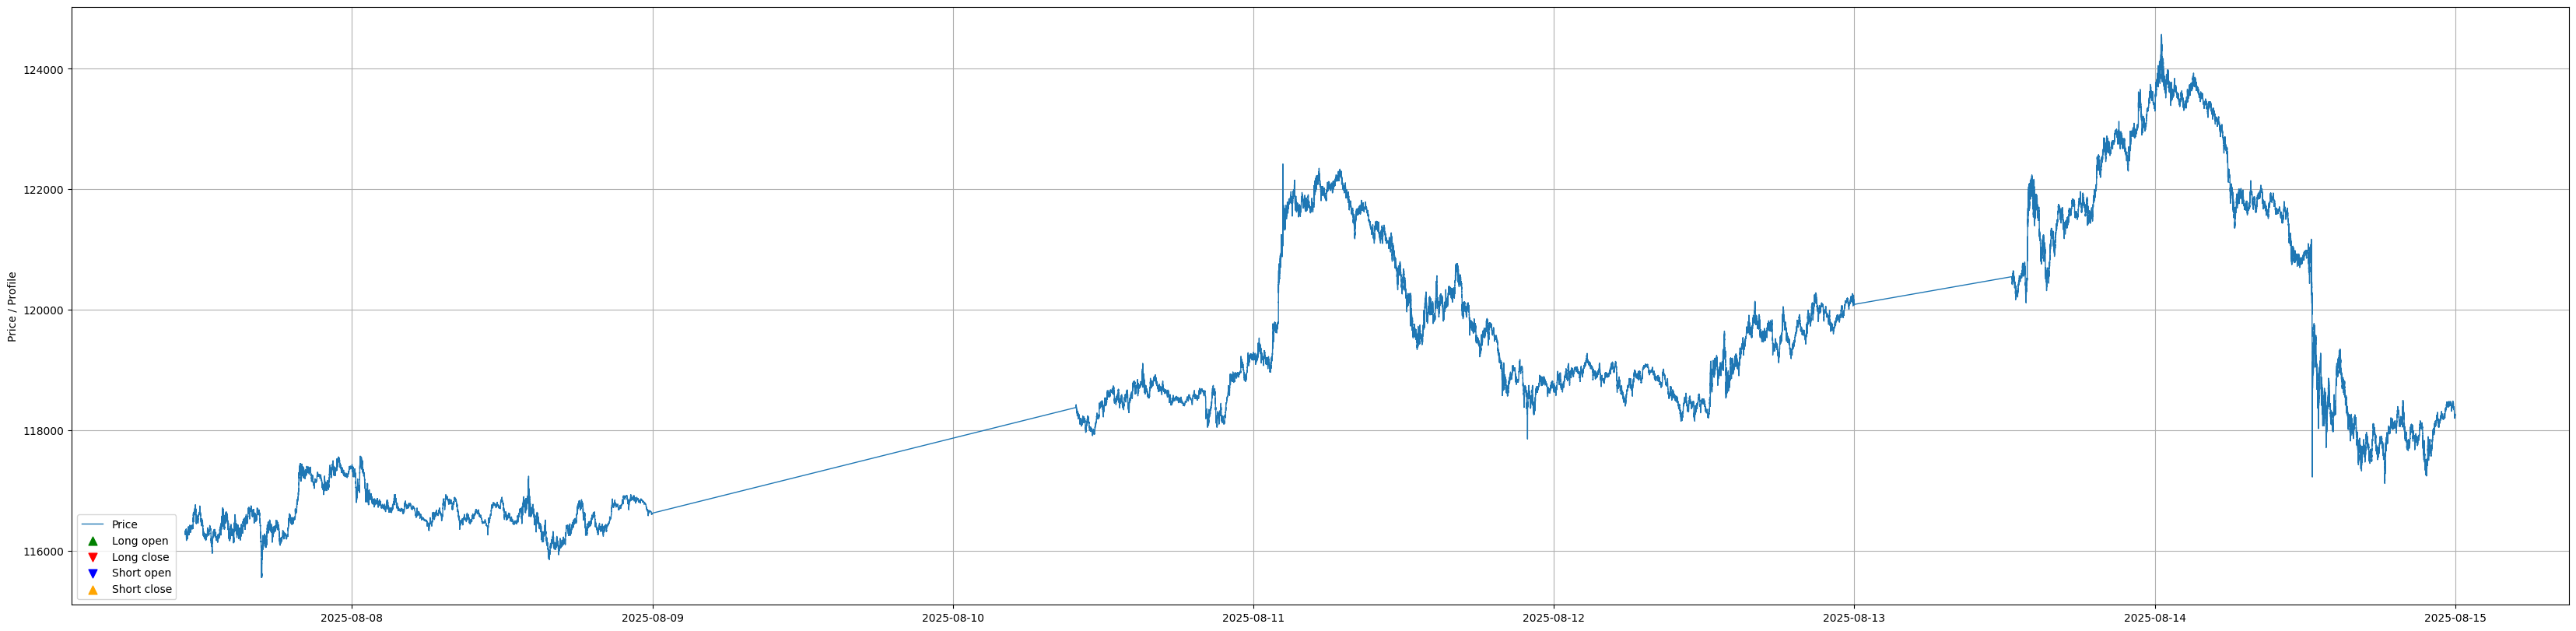

In [93]:
df = pd.concat(ticks_by_day, ignore_index=True)
df['recv_time']  = pd.to_datetime(df['recv_time'])

fig, ax0 = plt.subplots(#было fig, axes
    1, 1,#было 7 1
    figsize=(33, 8),
    constrained_layout=True,
    sharex=True,
    # gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1, 1]}
)
# ax0 = axes[0]

# цена
ax0.plot(df['recv_time'], df['price'], label='Price', linewidth=1)
# ax0.plot(indicators_df.index, indicators_df['VAH'], label='VAH')
# ax0.plot(indicators_df.index, indicators_df['VAL'], label='VAL')

# 1)разделяем trades на два списка
trades_long  = [t for t in trades if t['direction'] == 'long']
trades_short = [t for t in trades if t['direction'] == 'short']

# извлекаем отдельно entry/exit времена и цены для каждого направления
long_open_times  = [t['entry_time']  for t in trades_long]
long_open_prices = [t['entry_price'] for t in trades_long]
long_close_times  = [t['exit_time']  for t in trades_long]
long_close_prices = [t['exit_price'] for t in trades_long]

short_open_times  = [t['entry_time']   for t in trades_short]
short_open_prices = [t['entry_price']  for t in trades_short]
short_close_times  = [t['exit_time']   for t in trades_short]
short_close_prices = [t['exit_price']  for t in trades_short]

#наносим на график

ax0.scatter(long_open_times,  long_open_prices,  marker='^', color='g', s=60, label='Long open')
ax0.scatter(long_close_times, long_close_prices, marker='v', color='r', s=60, label='Long close')

ax0.scatter(short_open_times,  short_open_prices,  marker='v', color='b',      s=60, label='Short open')
ax0.scatter(short_close_times, short_close_prices, marker='^', color='orange', s=60, label='Short close')

ax0.set_ylabel("Price / Profile")
ax0.legend(loc='lower left')
ax0.grid(True)

# indicators = ['RF','VPIN','OFI','Kyle_Lambda','volume_delta', 'cum_delta']
# titles = ['Rotation Factor', 'VPIN', 'Order Flow Imbalance', "Kyle's Lambda", 'Volume Delta', 'Cummulutive Delta']

# for i, indicator in enumerate(indicators, start=1):
#     if indicator == 'volume_delta':
#         colors = np.where(indicators_df[indicator] >= 0, 'green', 'red')
#         axes[i].bar(indicators_df.index, indicators_df[indicator], color=colors, alpha=0.7, width=0.01)
#         axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
#     else:
#         axes[i].plot(indicators_df.index, indicators_df[indicator], label=titles[i-1], linewidth=1.2)
    
#     #ключевые уровни для каждого индикатора
#     if indicator == 'RF':
#         axes[i].axhline(0.5, color='gray', linestyle='--', alpha=0.7)
#         axes[i].axhline(2.0, color='gray', linestyle='--', alpha=0.7)
#     elif indicator == 'VPIN':
#         axes[i].axhline(0.1, color='gray', linestyle='--', alpha=0.7)
#         axes[i].axhline(0.3, color='gray', linestyle='--', alpha=0.7)
#     elif indicator == 'Kyle_Lambda':
#         axes[i].axhline(0.05, color='gray', linestyle='--', alpha=0.7)
#         axes[i].axhline(0.2, color='gray', linestyle='--', alpha=0.7)
#     elif indicator == 'OFI':
#         axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
#     elif indicator == 'cum_delta':
#         axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    
#     axes[i].set_ylabel(titles[i-1])
#     axes[i].grid(True, alpha=0.3)
#     axes[i].legend(loc='best')

# for ax in axes:
#     #локатор дат каждые 3 часа
#     ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    
#     #формат дата время
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    
#     #дополнительные минорные деления (каждый час)
#     ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    
#     #поворот меток
#     plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# plt.subplots_adjust(bottom=0.15)
# # plt.tight_layout()
# plt.show()

отрисовка дохода

In [94]:
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,4),sharex=True, sharey=False)

# # Стратегия
# pts = sorted(zip(times, equity), key=lambda x: x[0])
# times_sorted, equity_sorted = zip(*pts)

# ax0.plot(times_sorted, equity_sorted, label='Strategy Equity', linewidth=2)
# ax0.set_title("Strategy")
# ax0.set_xlabel("Time")
# ax0.set_ylabel("Equity, USD")
# ax0.legend()
# ax0.grid(True)
# # Сузим диапазон Y, чтобы мелкие изменения было видно:
# y_min = min(equity)*0.9995
# y_max = max(equity)*1.0005
# ax0.set_ylim(y_min, y_max)

# # Buy & Hold
# ax1.plot(bh_equity.index, bh_equity.values, 
#          label='Buy & Hold', color='orange', linewidth=2)
# ax1.set_title("Buy & Hold")
# ax1.set_xlabel("Time")
# ax1.legend()
# ax1.grid(True)


# plt.tight_layout()
# plt.show()

print(f'Strategy returns:\n{(equity[-1]-equity[0])/100:.3f} %, Balance: {equity[-1]:.3f}, Max drawdown: {min(equity)} ({(min(equity) - equity[0])/100:.3f}%)')
print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/100:.3f} %, Balance: {bh_equity[-1]:.3f}')


Strategy returns:
0.000 %, Balance: 10000.000, Max drawdown: 10000 (0.000%)
Buy&Hold returns:
1.674 %, Balance: 10167.356


/var/folders/9g/ksvcj0yd2b714fy6c81b26v00000gn/T/ipykernel_19068/1179482841.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/100:.3f} %, Balance: {bh_equity[-1]:.3f}')
